In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

Couldn't import dot_parser, loading of dot files will not be possible.


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
from sklearn.preprocessing import scale

In [4]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [5]:
def make_importances_df(importances, titles, scaled=False):
    if scaled:
        return pd.DataFrame(np.mean(np.vstack(list(importances)), axis=0), index = titles + ["%s_scaled" %n for n in titles], columns=["importance"]).sort("importance", inplace=False, ascending=False)
    else: 
        return pd.DataFrame(np.mean(np.vstack(list(importances)), axis=0), index = titles, columns=["importance"]).sort("importance", inplace=False, ascending=False)
        

In [38]:
from b1ar_feature_types import *
from get_variable_names import *
from b1ar_tica_config import *
from residue import Residue, Atom

In [39]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import scale
from random import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [40]:
#schemes = ["closest-heavy", "CA"]
#feature_name = "%s-CA" %ori_feature_name

In [41]:
rho = 0.1
rho_string = "0pt1"
lag_time = 5
n_components = 10
n_clusters = 25
n_samples = 1

rho = 0.01
rho_string = "0pt01"
lag_time=50
schemes = ["closest-heavy", "CA"]
ori_feature_name = copy.deepcopy(feature_name)
feature_name = "%s-CA" %ori_feature_name

#feature_name = "%s_phi_psi_chi2" %feature_name
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
#tica_dir = "%s-normalized" % ori_tica_dir
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)



/home/enf/md_simulations/B1AR/featuresall_residues_5f8u_hom_under_cutoff6A-CA
/home/enf/md_simulations/B1AR/featuresall_residues_5f8u_hom_under_cutoff6A-CA


In [42]:
tica_dir

'/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01'

In [10]:
tica_object = verboseload(projection_operator_dir)
print(tica_object.timescales_)

loading "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/phi_psi_chi2_allprot_tica_coords.h5"...
[ 1807.27577207   930.82557327   715.12014423   577.5271037    552.90096526
   471.41700734   429.5572142    418.77614562   389.1365181    374.5275853 ]


In [11]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=5, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(12, 7)
residue_importances_df.shape
(13, 3)
              feature_name      res_i      res_j  resid_i  resid_j  \
5   Thr166_Ca To Ala171_Ca  Thr166_Ca  Ala171_Ca      166      171   
2   Thr166_Ca To Ala169_Ca  Thr166_Ca  Ala169_Ca      166      169   
6   Asn167_Ca To Ala171_Ca  Asn167_Ca  Ala171_Ca      167      171   
7   Trp145_Ca To Thr166_Ca  Trp145_Ca  Thr166_Ca      145      166   
9   Phe164_Ca To Thr166_Ca  Phe164_Ca  Thr166_Ca      164      166   
8   Trp145_Ca To Asp163_Ca  Trp145_Ca  Asp163_Ca      145      163   
11  Val165_Ca To Asn167_Ca  Val165_Ca  Asn167_Ca      165      167   
3   Asn167_Ca To Ala169_Ca  Asn167_Ca  Ala169_Ca      167      169   
4   Phe164_Ca To Tyr170_Ca  Phe164_Ca  Tyr170_Ca      164      170   
0          Phe265 To Leu35     Phe265      Leu35      265       35   
1         Asp147 To Ala169     Asp147     Ala169      147      169   
10  Thr166_Ca To Asn167_Ca  Thr166_Ca  Asn167_Ca      166      167 

In [12]:
with open(feature_residues_pkl) as f:
    feature_names = pickle.load(f)

In [13]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_subsampled_features_file = "%s/features_subsampled.pkl" % tica_dir
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features[0], feature_names)
#subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file)

In [14]:
lag_time = 25
n_clusters = 25
clusterer_filename = clusterer25_clusters = os.path.join(tica_dir, "clusterer25_clusters_tICs2_3.h5")
msm_model_dir = "%s/msm_%dclusters_lag_time%d.h5" % (tica_dir, n_clusters, lag_time)
build_msm(clusterer_filename, lag_time=lag_time, msm_model_dir=msm_model_dir)
msm_object = verboseload(msm_model_dir)
prior_counts = 0.

loading "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/clusterer25_clusters_tICs2_3.h5"...
fitting msm to trajectories with 25 clusters and lag_time 25
MSM contains 2 strongly connected components above weight=0.04. Component 1 selected, with population 98.430935%
MarkovStateModel(ergodic_cutoff='on', lag_time=25, n_timescales=None,
         prior_counts=0.0, reversible_type='mle', sliding_window=True,
         verbose=True)
Saving "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/msm_25clusters_lag_time25.h5"... (<class 'msmbuilder.msm.msm.MarkovStateModel'>)
fitted msm to trajectories with 23 states
loading "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/msm_25clusters_lag_time25.h5"...


In [15]:
def calculate_cluster_averages_per_feature(clusterer, features):
  n_clusters = clusterer.n_clusters 
  concatenated_clusters = np.concatenate(clusterer.labels_)
  concatenated_features = np.concatenate(features)
  cluster_averages = np.zeros((n_clusters, concatenated_features.shape[1]))
  for i in range(0, n_clusters):
    rows = np.where(concatenated_clusters == i)[0]
    means = np.mean(concatenated_features[rows,:], axis=0)
    cluster_averages[i,:] = means
  return cluster_averages

In [16]:
def get_sample_coords(sample_indices, coords):
    sample_coords = []
    for cluster in range(0, np.shape(sample_indices)[0]):
        print("Looking at cluster %d" %cluster)
        cluster_coords = []
        if type(sample_indices[cluster][0]) not in [list, tuple]:
            traj_index_frame_tuples = [sample_indices[cluster]]
        else:
            traj_index_frame_tuples = sample_indices[cluster]
        for traj_index_frame_tuple in traj_index_frame_tuples:
            traj_index = traj_index_frame_tuple[0]
            frame = traj_index_frame_tuple[1]
            cluster_coords.append(coords[traj_index][frame])
        cluster_coords = np.vstack(cluster_coords)
        sample_coords.append(cluster_coords)
    return sample_coords

In [17]:
feature_indices = []
traj_basenames = get_trajectory_files(traj_dir, ".h5")
traj_basenames = [os.path.splitext(os.path.basename(t))[0] for t in traj_basenames]
feature_basenames = get_trajectory_files(features_dir, ".dataset")
feature_basenames = [os.path.splitext(os.path.basename(t))[0] for t in feature_basenames]
for i, traj_basename in enumerate(traj_basenames):
    if traj_basename in feature_basenames:
        feature_indices.append(int(i))

tica_coords = verboseload(projected_features_dir)
pnas_coords = verboseload(user_defined_features_file)
pnas_coords = [pnas_coords[i] for i in feature_indices]
tica_names = ["tIC.%d" %i for i in range(1,n_components+1)]
pnas_names = sorted(feature_name_residues_dict.keys())

loading "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/B1AR/all_pnas_features/user_defined_features.h5"...


In [20]:
clusterer = verboseload(clusterer_dir)
cluster_averages = calculate_cluster_averages_per_feature(clusterer, pnas_coords)


loading "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/clusterer_1000clusters.h5"...


In [23]:
cluster_averages = pd.DataFrame(cluster_averages, columns=pnas_names)
active_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] < 0.5) & (cluster_averages["tm6_tm3_packing"] > 12.) & (cluster_averages["tm6_tm3_packing"] < 15.)]
inactive_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] > 0.5) & (cluster_averages["tm6_tm3_packing"] <10.)]

In [20]:
precision = "XP"
n_clusters=25
n_samples=1
docking_dir = "%s/docking_%s_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, precision, n_clusters, n_samples)
if not os.path.exists(docking_dir):
    os.makedirs(docking_dir)
grid_dir = "%s/grids_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(grid_dir):
    os.makedirs(grid_dir)

In [21]:
all_ligands = get_ligands("/home/enf/b2ar_analysis/all_ligands")
analyze_docking_results_multiple(docking_dir, precision = precision, ligands = all_ligands, summary = docking_multiple_ligands, redo = True)
c = compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)

#compute_aggregate_scores(docking_multiple_ligands, inverse_agonists = inverse_ligands, summary = aggregate_docking, z_scores_csv = docking_z_scores_csv)
#aggregate_docking_joined_map = convert_csv_to_joined_map(aggregate_docking, aggregate_docking_joined)[0]
#aggregate_docking_means = calc_mean(aggregate_docking_joined_map)
#write_map_to_csv(aggregate_docking_joined, aggregate_docking_means, ["cluster", "mean_aggregate_docking_z_score"])
#r['do.analysis'](tica_dir, analysis_dir, pnas_coords_csv, tica_coords_csv, features_dir, docking_multiple_ligands)
#tics_vs_docking_file = "%s/tICA_vs_docking_carazolol.pdf" % analysis_dir
#plot_tICs_vs_docking(docking_multiple_ligands, tica_coords_csv, tics_vs_docking_file, chosen_ligand="s-carazolol")


Analyzing docking results
/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/docking_XP_clusterer_25clusters_1samples_samples_kdtree
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '3p0g_lig', "4'-Methoxyfenoterol", 'BRL 37344', 'Ici118551', 'Ici215001', 'Ici89406', 'MAPE', 'N-Cyclopentylbutanephrine', 'Structure2D_CID_3343', 'TERBSN', 'Tulobuterol', 'ZINC_results-single', 'acebutolol', 'adrenalone', 'ah3021', 'ah3474', 'alprenalol', 'bevantolol', 'bisoprolol', 'broxaterol', 'bucindolol', 'bupranolol', 'cgp12177', 'cicloprolol', 'cimaterol', 'clenbuterol', 'clenproperol', 'dichloroisopreterenol', 'dobutamine', 'dopamine', 'du211117', 'du28663', 'epinine', 'ethylnorepinephrine', 'fenoterol', 'formoterol

In [22]:
c

,Structure2D_CID_3343,dobutamine,isoetharine,broxaterol,bevantolol,pindolol,r_isopreterenol,nor-metanephrine,bucindolol,clenbuterol,...,formoterol,ah3474,clenproperol,du211117,isopropylnorsynephrine,norepinephrine,sotalol,zinterol,olodaterol,du28663
cluster0,10.24,12.09,10.17,5.15,8.19,8.79,9.05,8.02,0.00,7.68,...,11.49,8.76,0.00,8.83,8.75,9.67,8.06,12.94,10.99,8.48
cluster10,8.73,8.07,7.88,4.81,6.60,6.41,7.04,5.60,8.18,6.61,...,8.33,6.63,6.20,6.50,5.78,7.28,6.21,7.29,6.69,5.72
cluster11,10.65,9.23,8.52,6.40,9.15,9.03,8.66,6.95,9.34,7.78,...,7.93,8.47,8.27,8.70,6.90,6.99,6.40,9.31,8.17,6.57
cluster12,11.11,11.96,9.39,6.58,9.28,8.07,9.29,8.00,10.66,8.15,...,9.38,8.56,9.11,8.02,7.91,8.54,7.31,9.44,10.24,7.67
cluster13,7.92,0.00,0.00,5.47,7.76,8.28,7.92,6.63,9.80,0.00,...,0.00,7.90,5.83,5.27,5.78,7.81,6.73,8.74,8.12,6.22
cluster14,9.48,9.25,6.82,5.04,8.41,7.16,6.29,6.00,10.51,6.11,...,8.05,7.50,6.05,5.65,5.15,6.28,6.62,9.28,8.25,5.65
cluster15,8.10,7.90,5.96,4.86,6.86,6.04,6.92,7.06,8.37,6.56,...,9.28,7.03,7.08,6.92,5.42,7.75,5.37,8.09,7.16,6.75
cluster17,8.60,9.82,7.98,5.38,9.34,6.00,7.02,6.60,10.17,7.14,...,9.52,8.61,8.41,6.61,7.38,7.88,6.06,9.44,8.24,5.71
cluster18,8.86,8.54,7.38,5.11,7.86,6.31,6.53,6.70,9.18,5.40,...,6.74,5.63,5.86,5.62,5.47,6.99,6.43,8.59,6.92,5.39
cluster19,10.81,11.93,8.97,5.92,8.69,8.45,0.00,7.25,12.82,5.32,...,0.00,7.16,7.52,7.75,7.63,8.35,7.49,9.89,12.31,8.33


In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
rank_tICs_by_docking_logistic(None, None, analysis_dir, docking_csv=docking_multiple_ligands, tica_coords_csv=tica_coords_csv)

In [24]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

import pickle
with open(feature_residues_pkl, "rb") as f:
    feature_residues = pickle.load(f)

clusterer = verboseload(clusterer_dir)

tica_coords = verboseload(projected_features_dir)
user_defined_coords = pnas_coords

pp_n_components = n_components
apriori_dfs = []
for array in user_defined_coords:
    apriori_dfs.append(pd.DataFrame(array, columns=pnas_names))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["tIC.%d" %i for i in range(1,n_components+1)]))

cluster_pnas_averages = calculate_cluster_averages_per_feature(clusterer, user_defined_coords)
cluster_pnas_averages = pd.DataFrame(cluster_pnas_averages, columns=pnas_names)

cluster_tica_averages = calculate_cluster_averages_per_feature(clusterer, tica_coords)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, n_components+1)])
cluster_tica_pnas = pd.concat([cluster_pnas_averages, cluster_tica_averages], axis=1).dropna()

top_features = load_file(tic_subsampled_features_file)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
clusters_map = make_clusters_map(clusterer)
tica_resampled_file = os.path.join(tica_dir, "tica_msm_lag-time%d_clusters%d_resampled.h5" %(lag_time, n_clusters))
projected_features = verboseload(projected_features_dir)

num_trajs = len(get_trajectory_files(traj_dir, traj_ext))

def reweight_features_by_msm(msm_object):
    total_samples = 10000
    resampled_traj_to_frames_file = os.path.join(tica_dir, "msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(lag_time, str(prior_counts), n_clusters, total_samples))
    resampled_traj_to_frames = resample_by_msm(total_samples, msm_object, clusters_map, num_trajs, resampled_traj_to_frames_file)

    resample_features_by_msm_equilibirum_pop(projected_features, resampled_traj_to_frames, tica_resampled_file)
    tica_resampled = verboseload(tica_resampled_file)
    pnas_resampled_file = os.path.join(tica_dir, "pnas_resampled.h5")
    resample_features_by_msm_equilibirum_pop(user_defined_coords, resampled_traj_to_frames, pnas_resampled_file)
    pnas_resampled = verboseload(pnas_resampled_file)

    resampled_traj_index_pairs = []
    for traj in resampled_traj_to_frames.keys():
        [resampled_traj_index_pairs.append((traj, frame)) for frame in resampled_traj_to_frames[traj]]


    features_eq = resample_features_by_msm_trajectory(top_features, resampled_traj_index_pairs)*10.
    tica_eq = pd.DataFrame(tica_resampled, columns=["tIC.%d" %i for i in range(1,n_components+1)])
    pnas_eq = pd.DataFrame(pnas_resampled, columns=pnas_names)
    features_eq = pd.concat([features_eq, tica_eq, pnas_eq], axis=1)
    features_eq.columns = [str(f) for f in features_eq.columns.values.tolist()]

    str_features = list(set([str(g) for l in important_contact_features[1] for g in l]))
    f0 = pd.concat([f*10. for f in top_features], axis=0)
    f2 = pd.concat([f for f in tica_dfs])
    f3 = pd.concat([f for f in apriori_dfs])
    prot_lig_features = pd.concat([f0,f2,f3],axis=1)
    all_traj_features = [pd.concat([top_features[i]*10., tica_dfs[i], apriori_dfs[i]], axis=1) for i in range(0, len(tica_dfs))]
    return features_eq, all_traj_features


n_steps = 100000
save_file = "%s/msm_traj_index_pairs.h5" % (tica_dir)
#msm_traj_index_pairs = generate_msm_traj_index_series(msm_object, random.choice(active_clusters.index.values.tolist()), n_steps, bu72_pp_clusters_map, save_file)
#msm_traj_index_pairs = verboseload(save_file)
features_eq, all_traj_features = reweight_features_by_msm(msm_object)

loading "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/clusterer_1000clusters.h5"...
loading "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/phi_psi_chi2_allprot_projected.h5"...
loading /home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/features_subsampled.pkl
16
24
16
17
24
14
20
22
25
34
116
20
22
43
47
15
100
62
16
42
23
27
37
18
115
6
8
92
8
21
35
37
8
7
14
31
45
33
61
16
48
13
25
46
12
118
5
31
36
38
52
105
46
18
10
56
80
73
12
44
14
12
77
29
68
38
15
45
13
57
18
3
39
13
20
8
45
40
4
79
43
21
10
37
24
89
57
35
88
20
39
10
13
12
61
72
81
2
32
21
12
37
25
13
13
50
51
26
24
38
41
60
47
60
91
19
5
26
34
26
79
59
46
24
40
27
99
18
52
53
43
101
15
31
44
28
24
74
12
14
20
12
22
55
36
27
58
25
8
20
76
45
44
58
16
13
24


In [48]:

samples_dir = "%s/clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir):
    os.makedirs(samples_dir)
#sample_from_clusterer(clusterer_dir, projected_features_dir, get_trajectory_files(traj_dir, ".h5"), 
#                      n_samples, samples_dir, samples_indices_file, structure=None,
#                      residue_cutoff=10000, parallel=True,
#                      worker_pool=None)
#clusters_map = make_clusters_map(verboseload(clusterer_dir))

In [49]:
from msmbuilder.utils import verbosedump, verboseload
samples_indices = verboseload(samples_indices_file)
tica_coords = verboseload(projected_features_dir)
#features = load_file_list(get_trajectory_files(features_dir, ".dataset"), directory = None, ext = None)
samples_tica = []
samples_pnas = []
samples_features = []


loading "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/clusterer_25clusters_1samples_samples_kdtree_indices.h5"...
loading "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/phi_psi_chi2_allprot_projected.h5"...


In [50]:
samples_tica_file = "%s/clusterer_%dclusters_%dsamples_samples_kdtree_tica.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_tica_file):
    samples_tica = get_sample_coords(samples_indices, tica_coords)
    verbosedump(samples_tica, samples_tica_file)
samples_tica = verboseload(samples_tica_file)
samples_tica_avg_df = pd.DataFrame([np.mean(t, axis=0) for t in samples_tica], index=["cluster%d" %i for i in range(0,n_clusters)], columns=["tIC.%d" %i for i in range(1, n_components+1)])

samples_pnas_file = "%s/clusterer_%dclusters_%dsamples_samples_kdtree_pnas.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_pnas_file):
    samples_pnas = get_sample_coords(samples_indices, pnas_coords)
    verbosedump(samples_pnas, samples_pnas_file)
samples_pnas = verboseload(samples_pnas_file)
samples_pnas_avg_df = pd.DataFrame([np.mean(t, axis=0) for t in samples_pnas], index=["cluster%d" %i for i in range(0,n_clusters)], columns=["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"])



#samples_features = get_sample_coords(samples_indices, features)
samples_features_file = "%s/clusterer_%dclusters_%dsamples_samples_kdtree_features.h5" %(tica_dir, n_clusters, n_samples)
#verbosedump(samples_features, samples_features_file)
samples_features = verboseload(samples_features_file)
samples_features_avg_df = pd.DataFrame([np.mean(t, axis=0) for t in samples_features], index=["cluster%d" %i for i in range(0,n_clusters)])


from sklearn.preprocessing import StandardScaler
#n = StandardScaler()
#n.fit(np.concatenate(features))
#normalized_features = [n.transform(f) for f in features]

#samples_normalized_features = get_sample_coords(samples_indices, normalized_features)
samples_normalized_features_file = "%s/clusterer_%dclusters_%dsamples_samples_kdtree_features_normalized.h5" %(tica_dir, n_clusters, n_samples)
#verbosedump(samples_normalized_features, samples_normalized_features_file)
samples_normalized_features = verboseload(samples_normalized_features_file)
samples_normalized_features_avg_df = pd.DataFrame([np.mean(t, axis=0) for t in samples_normalized_features], index=["cluster%d" %i for i in range(0,n_clusters)], columns=[str(f) for f in feature_names])



loading "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/clusterer_25clusters_1samples_samples_kdtree_tica.h5"...


IOError: Unable to load /home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/clusterer_25clusters_1samples_samples_kdtree_tica.h5 using the pickle or joblib protocol.
Pickle: [Errno 2] No such file or directory: '/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/clusterer_25clusters_1samples_samples_kdtree_tica.h5'
Joblib: [Errno 2] No such file or directory: '/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components10all_residues_5f8u_hom_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/clusterer_25clusters_1samples_samples_kdtree_tica.h5'

In [46]:
import pickle
with open(feature_residues_pkl, "rb") as f:
    feature_names = pickle.load(f)
feature_strings = [str(feature_name) for feature_name in feature_names]
samples_normalized_features_averages = [np.mean(f, axis=0) for f in samples_normalized_features]
samples_normalized_features_averages_df = pd.DataFrame(samples_normalized_features_averages, columns=feature_strings)

samples_pnas_tica = pd.concat([samples_pnas_avg_df, samples_tica_avg_df], axis=1)

NameError: name 'samples_normalized_features' is not defined

In [34]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [35]:
samples_pnas_avg_df.sort("rmsd_npxxy_active", inplace=False)

,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active
cluster2,14.403458,0.994941,0.268876,1.831260,1.361117
cluster10,7.171780,0.645269,0.676383,0.602726,1.272425
cluster19,8.595222,0.456841,0.732804,0.326674,1.298181
cluster23,12.866024,0.486451,0.761240,0.303495,1.378049
cluster17,8.218304,0.424519,0.786499,0.422930,1.508190
cluster3,13.353683,0.579279,0.802554,0.792276,1.433377
cluster8,12.638399,0.401345,0.806741,0.363658,1.483838
cluster22,7.380744,0.503686,0.817174,0.234265,1.483722
cluster14,7.668878,0.588931,0.837820,0.286814,1.498951
cluster12,9.520415,0.454414,0.854156,0.233577,1.390169


In [36]:
agonist_ligands = get_ligands(agonist_dir)
print(agonist_ligands)
biased_ligands = get_ligands(biased_agonist_dir)
print(biased_ligands)

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '3p0g_lig', "4'-Methoxyfenoterol", 'BRL 37344', 'Ici215001', 'Ici89406', 'MAPE', 'N-Cyclopentylbutanephrine', 'Structure2D_CID_3343', 'TERBSN', 'Tulobuterol', 'acebutolol', 'adrenalone', 'ah3021', 'ah3474', 'alprenalol', 'bevantolol', 'bisoprolol', 'broxaterol', 'bucindolol', 'bupranolol', 'cgp12177', 'cicloprolol', 'cimaterol', 'clenbuterol', 'clenproperol', 'dichloroisopreterenol', 'dobutamine', 'dopamine', 'du211117', 'du28663', 'epinine', 'ethylnorepinephrine', 'fenoterol', 'formoterol', 'hexoprenaline', 'isopropylnorsynephrine', 'labetalol', 'metoprolol', 'nadolol', 'nipradilol', 'nor-metanephrine', 'norepinephrine', 'olodaterol', 'orciprenaline', 'pindolol', 'practolol', 'procaterol', 'pronethalol 2', 'pronethalol', 'r_epinephrine', 'r_isopreterenol',

In [28]:
docking_multiple_ligands = "%s/all_docking_scores.csv" % docking_dir
aggregate_docking = "%s/aggregate_docking.csv" % docking_dir
print(biased_ligands + agonist_ligands)

print(docking_multiple_ligands)

#analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands + mehrdad_ligands + inverse_ligands, summary = docking_multiple_ligands, redo = True)
#analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands, summary = docking_multiple_ligands, redo = True)


#compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)



NameError: name 'biased_ligands' is not defined

In [38]:
pd.set_option('display.max_columns', None)

In [29]:
df_agg = c
#df_agg = pd.read_csv(aggregate_docking, index_col=0).dropna()
#df_agg = pd.read_csv(docking_multiple_ligands, index_col=0).dropna()
df_agg.index = [n.split("_")[0] for n in df_agg.index.values]


df_agg.columns = [''.join(e for e in lig if e.isalnum() or e=='-' or e=='_') for lig in df_agg.columns.values]
msm_obj =msm_object

msm_clusters = msm_obj.mapping_.keys()
msm_cluster_names = []
msm_cluster_eq_pops = []
for cluster_id in msm_clusters:
    cluster_name = "cluster%d" %cluster_id
    if cluster_name in df_agg.index.values:
        state_id = msm_obj.mapping_[cluster_id]
        msm_cluster_eq_pops.append(msm_obj.populations_[state_id])
        msm_cluster_names.append(cluster_name)
msm_cluster_eq_pops = np.array(msm_cluster_eq_pops)
msm_cluster_deltaG = -0.61 * np.log(msm_cluster_eq_pops)
msm_cluster_eq_pops_df = pd.DataFrame(msm_cluster_eq_pops, index=msm_cluster_names)
aggregate_docking_msm = df_agg.loc[msm_cluster_names]

samples_tica_avg_df = samples_tica_avg_df.loc[msm_cluster_names]
samples_pnas_avg_df = samples_pnas_avg_df.loc[msm_cluster_names]
samples_top_features_avg_df = samples_normalized_features_avg_df[[str(f) for f in important_contact_features[0]]].loc[msm_cluster_names]
print(aggregate_docking_msm.columns)

ligand = "3p0g_lig"

apo_deltaG = msm_cluster_deltaG - (-1.0 * aggregate_docking_msm[ligand].values)

apo_populations = np.exp(-1.0*apo_deltaG / 0.61)
Z_apo = np.sum(apo_populations)
apo_populations = apo_populations / Z_apo
apo_eq_pops_df = copy.deepcopy(msm_cluster_eq_pops_df)
apo_eq_pops_df[apo_eq_pops_df.columns] = apo_populations.reshape((-1,1))
apo_deltaG = -.61 * np.log(apo_populations)

msm_cluster_eq_pops = apo_populations
msm_cluster_deltaG = apo_deltaG
msm_cluster_eq_pops_df = apo_eq_pops_df


new_populations = copy.deepcopy(aggregate_docking_msm)
for ligand in aggregate_docking_msm.columns.values:
    new_populations[ligand] = np.exp(-1.0*(-1.0*aggregate_docking_msm[ligand].values+msm_cluster_deltaG)/0.61)

Z = np.sum(new_populations.values, axis=0)
for j, ligand in enumerate(aggregate_docking_msm.columns.values):
    new_populations[ligand] = new_populations[ligand].values / Z[j]
population_deltas = copy.deepcopy(new_populations)
for ligand in aggregate_docking_msm.columns.values:
    population_deltas[ligand] = population_deltas[ligand].values / msm_cluster_eq_pops
new_energies = copy.deepcopy(new_populations)
for ligand in aggregate_docking_msm.columns.values:
    new_energies[ligand] = -.61 * np.log(new_populations[ligand])
delta_delta_g = copy.deepcopy(new_energies)
for ligand in aggregate_docking_msm.columns.values:
    delta_delta_g[ligand] = new_energies[ligand].values - msm_cluster_deltaG


docking_normalized = copy.deepcopy(aggregate_docking_msm)
docking_normalized[docking_normalized.columns.values] = scale(docking_normalized.values)

ddg_scaled = copy.deepcopy(delta_delta_g)
ddg_scaled[delta_delta_g.columns.values] = scale(delta_delta_g.values)
    
deltas_tica = pd.concat([delta_delta_g, samples_tica_avg_df, samples_pnas_avg_df, samples_top_features_avg_df], axis=1)

#print(deltas_tica.iloc[0:10])


docking_normalized[docking_normalized.columns.values] = scale(population_deltas.values)

train_biased_antagonists = ["s-carvedilol", "nebivolol"] 
train_inverse_agonists = [] #["s-carazolol", "Ici118551"]"

train_arrestin_agonists = ["isoetharine", "3p0g_lig"]
train_gprot_agonists = ["procaterol"]

train_agonists = ["r_isopreterenol"] + train_arrestin_agonists + train_gprot_agonists

indices = []
for biased_antagonist in (train_biased_antagonists):# + train_arrestin_agonists):
    for inverse_agonist in train_inverse_agonists:
        bias_antagonist_minus_antagonists = delta_delta_g[biased_antagonist].values - delta_delta_g[inverse_agonist].values
        #bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)
        indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))
    indices.append(set(np.where(scale(delta_delta_g[biased_antagonist].values) <-1.)[0]))

#if train_gprot_agonists is not None:
#    for biased_antagonist in train_arrestin_agonists:
#        for inverse_agonist in (train_gprot_agonists):
#            bias_antagonist_minus_antagonists = delta_delta_g[biased_antagonist].values - delta_delta_g[inverse_agonist].values
#            #bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)
#            indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))
#        indices.append(set(np.where(delta_delta_g[biased_antagonist].values <0)[0]))


indices = set.intersection(*indices)
#bias_antagonist_minus_agonists = deltas_tica[[" 3p0g_lig"]].mean(axis=1).values - deltas_tica[train_agonists].mean(axis=1).values
#bias_antagonist_minus_agonists = scale(bias_antagonist_minus_agonists)
#indices = list(set(np.where(bias_antagonist_minus_antagonists < -.5)[0]))#.tolist()).intersection(set(np.where(bias_antagonist_minus_antagonists > 1.)[0].tolist())))
biased_antagonist_states = deltas_tica.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]
print("biased antagonist states")
print(indices)

#biased_antagonist_states = biased_antagonist_states.loc[biased_antagonist_states["tm6_tm3_dist"] > 12.]

indices = []

for biased_antagonist in train_agonists:
    for inverse_agonist in (train_inverse_agonists):
        bias_antagonist_minus_antagonists = delta_delta_g[biased_antagonist].values - delta_delta_g[inverse_agonist].values
        bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)
        indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))
        #indices.append(set(np.where(delta_delta_g[inverse_antagonist].values > -.5)[0]))
    indices.append(set(np.where(delta_delta_g[biased_antagonist].values <-0.)[0]))
indices = set.intersection(*indices)
agonist_states = deltas_tica.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]
#agonist_states = agonist_states.loc[agonist_states["tm6_tm3_dist"] > 12.]
print("agonist states:")
print(indices)

indices = []
for biased_antagonist in train_arrestin_agonists:
    for inverse_agonist in (train_gprot_agonists):
        bias_antagonist_minus_antagonists = agonist_states[biased_antagonist].values - agonist_states[inverse_agonist].values
        bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)
        indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))
        #indices.append(set(np.where(delta_delta_g[inverse_antagonist].values > -.5)[0]))
    indices.append(set(np.where(agonist_states[biased_antagonist].values <-0.)[0]))
indices = set.intersection(*indices)
arrestin_agonist_states = agonist_states.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]
print("arrestin agonist states:")
print(indices)

indices = []
for biased_antagonist in train_gprot_agonists:
    for inverse_agonist in (train_arrestin_agonists):
        bias_antagonist_minus_antagonists = agonist_states[biased_antagonist].values - agonist_states[inverse_agonist].values
        bias_antagonist_minus_antagonists = scale(bias_antagonist_minus_antagonists)
        indices.append(set(np.where(bias_antagonist_minus_antagonists < -0.)[0]))
        #indices.append(set(np.where(delta_delta_g[inverse_antagonist].values > -.5)[0]))
    indices.append(set(np.where(agonist_states[biased_antagonist].values <-0.)[0]))
indices = set.intersection(*indices)
gprot_agonist_states = agonist_states.iloc[list(indices)]#.intersection(set(np.where(np.max(scale(deltas_tica[train_biased_antagonists].values),axis=1) < -.5)[0])))]
print("gprot agonist states:")
print(indices)


NameError: name 'samples_tica_avg_df' is not defined

In [ ]:
inactive_clusters = samples_pnas_tica.loc[samples_pnas_tica["tm6_tm3_dist"] < 11.].index.values
print(inactive_clusters)

In [ ]:
from msm_resampled import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
BI_msm_resampled_file = "%s/msm_tICs_1_2_3_BI167107_eq_resampled.h5"
eq_pops = bi_msm.populations_
bi_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=BI_msm_resampled_file, equilibrium_populations=eq_pops)
BI_tICA_resampled_file = "%s/msm_tICs_1_2_3_BI167107_eq_tICA_resampled.h5"
resample_features_by_msm_equilibirum_pop(verboseload(projected_features_dir), bi_traj_to_frames, BI_tICA_resampled_file)

In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_columns(analysis_dir, BI_tICA_resampled_file, titles = ["tIC%d" %j for j in range(1,n_components+1)], main="BI 167107 MSM", tICA = True, scale = 1.0, refcoords_file = ref_tica_coords, concatenate=False, reshape=False)


In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
#min_density = min(new_populations["3p0g_lig"].values)
min_density=7.0
#jointplots(verboseload(BI_tICA_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "BI 167107 MSM", refcoords_file = ref_tica_coords, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2, min_density=min_density)

In [ ]:
from msm_resampled import *
from jointplot_d3 import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
apo_msm_resampled_file = "%s/msm_tICs_1_2_3_apo_eq_resampled.h5"
eq_pops = apo_populations
msm_apo_populations = np.zeros(len(eq_pops))
for cluster_id in bi_msm.mapping_.keys():
    msm_apo_populations[bi_msm.mapping_[cluster_id]] = eq_pops[cluster_id]
apo_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=apo_msm_resampled_file, equilibrium_populations=msm_apo_populations)
apo_tICA_resampled_file = "%s/msm_tICs_1_2_3_apo_eq_tICA_resampled.h5"
resample_features_by_msm_equilibirum_pop(verboseload(projected_features_dir), apo_traj_to_frames, apo_tICA_resampled_file)
jointplots(verboseload(apo_tICA_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "APO MSM", refcoords_file = ref_tica_coords, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2, min_density=min_density)

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
from msm_resampled import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
ligands = ["bisoprolol", "nebivolol"]
ligands = ["N-Cyclopentylbutanephrine", "3p0g_lig", "salmeterol", "salbutamol", "r_isopreterenol", "r_epinephrine", "isoetharine", "nebivolol", "s-carvedilol", "s-carazolol", "norepinephrine", "ethylnorepinephrine"]
#ligands = ["Ici118551", "propranolol", "s-atenolol", "pindolol", "s-carvedilol", "xamoterol", "s-carazolol", "3p0g_lig", "r_isopreterenol", "norepinephrine", "r_epinephrine", "ethylnorepinephrine", "isoetharine"]
lig_features_eq = {}
for ligand in ligands:
    lig_msm_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_resampled.h5" %(tica_dir, ligand)
    eq_pops = new_populations[ligand]
    msm_lig_populations = np.zeros(len(eq_pops))
    for cluster_id in bi_msm.mapping_.keys():
        msm_lig_populations[bi_msm.mapping_[cluster_id]] = eq_pops[cluster_id]
    new_msm = copy.deepcopy(bi_msm)
    new_msm.populations_ = msm_lig_populations
    lig_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=lig_msm_resampled_file, equilibrium_populations=msm_lig_populations)
    lig_tICA_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_tICA_resampled.h5" %(tica_dir, ligand)
    #resample_features_by_msm_equilibirum_pop(verboseload(projected_features_dir), lig_traj_to_frames, lig_tICA_resampled_file)
    #jointplots(verboseload(lig_tICA_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "%s MSM" %ligand, refcoords_file = ref_tica_coords, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2,min_density=min_density, custom_xlim=[-1500, 1300], custom_ylim=[-1000,1000], max_diff=3.0)
    lig_features_eq[ligand], _ = reweight_features_by_msm(new_msm)
    #plt.hist(lig_features_eq["Asn148_Leu266"], bins=100, range=[10,45])
    #plt.title("Asn148-Leu266")
    #break

In [68]:
plt.hist(features_eq["Asn148 To Leu266"], bins=100, range=[10,45])
plt.title("Asn148-Leu266")

KeyError: 'Asn148 To Leu266'

In [69]:
features_eq.shape

(10000, 19)

In [ ]:
plt.hist(lig_features_eq["tm6_tm3_dist"], bins=100, range=[5,20])

In [ ]:
plt.hist(features_eq["tm6_tm3_dist"], bins=100, range=[5,20])

In [ ]:
n, bins, patches = plt.hist(lig_features_eq["Asn148_Leu266"], bins=100)

In [ ]:
from scipy import stats
thr_x = np.linspace(5, 50, 500)
thr_kde1 = stats.gaussian_kde(lig_features_eq["norepinephrine"]["Thr66_Leu266"])
thr_kde2 = stats.gaussian_kde(lig_features_eq["ethylnorepinephrine"]["Thr66_Leu266"])
thr_dx1 = thr_kde1(thr_x)
thr_dx2 = thr_kde2(thr_x)
plt.plot(thr_x,thr_dx1-thr_dx2)

In [ ]:
from scipy import stats
thr_x = np.linspace(5, 50, 500)
thr_kde1 = stats.gaussian_kde(lig_features_eq["r_epinephrine"]["Asn148_Leu266"])
thr_kde2 = stats.gaussian_kde(lig_features_eq["r_isopreterenol"]["Asn148_Leu266"])
thr_dx1 = thr_kde1(thr_x)
thr_dx2 = thr_kde2(thr_x)
plt.plot(thr_x,thr_dx1-thr_dx2)

In [ ]:
from scipy import stats
thr_x = np.linspace(0,3.,500)
thr_kde1 = stats.gaussian_kde(lig_features_eq["r_isopreterenol"]["rmsd_npxxy_active"])
thr_kde2 = stats.gaussian_kde(lig_features_eq["s-carazolol"]["rmsd_npxxy_active"])
thr_dx1 = thr_kde1(thr_x)
thr_dx2 = thr_kde2(thr_x)
plt.plot(thr_x,thr_dx1-thr_dx2)

In [ ]:
from scipy import stats
thr_x = np.linspace(5, 50, 500)
thr_kde1 = stats.gaussian_kde(lig_features_eq["isoetharine"]["Asn148_Leu266"])
thr_kde2 = stats.gaussian_kde(lig_features_eq["r_isopreterenol"]["Asn148_Leu266"])
thr_dx1 = thr_kde1(thr_x)
thr_dx2 = thr_kde2(thr_x)
plt.plot(thr_x,thr_dx1-thr_dx2)

In [ ]:
from scipy import stats
thr_x = np.linspace(5, 50, 500)
thr_kde1 = stats.gaussian_kde(lig_features_eq["N-Cyclopentylbutanephrine"]["Asn148_Leu266"])
thr_kde2 = stats.gaussian_kde(lig_features_eq["r_isopreterenol"]["Asn148_Leu266"])
thr_dx1 = thr_kde1(thr_x)
thr_dx2 = thr_kde2(thr_x)
plt.plot(thr_x,thr_dx1-thr_dx2)

In [ ]:
from scipy import stats
thr_x = np.linspace(5, 50, 500)
thr_kde1 = stats.gaussian_kde(lig_features_eq["ethylnorepinephrine"]["Asn148_Leu266"])
thr_kde2 = stats.gaussian_kde(lig_features_eq["r_isopreterenol"]["Asn148_Leu266"])
thr_dx1 = thr_kde1(thr_x)
thr_dx2 = thr_kde2(thr_x)
plt.plot(thr_x,thr_dx1-thr_dx2)

In [ ]:
from scipy import stats
thr_x = np.linspace(5, 50, 500)
thr_kde1 = stats.gaussian_kde(lig_features_eq["salbutamol"]["Asn148_Leu266"])
thr_kde2 = stats.gaussian_kde(lig_features_eq["r_isopreterenol"]["Asn148_Leu266"])
thr_dx1 = thr_kde1(thr_x)
thr_dx2 = thr_kde2(thr_x)
plt.plot(thr_x,thr_dx1-thr_dx2)

In [ ]:
from scipy import stats
thr_x = np.linspace(5, 20, 500)
thr_kde1 = stats.gaussian_kde(lig_features_eq["N-Cyclopentylbutanephrine"]["tm6_tm3_dist"])
thr_kde2 = stats.gaussian_kde(lig_features_eq["r_isopreterenol"]["tm6_tm3_dist"])
thr_dx1 = thr_kde1(thr_x)
thr_dx2 = thr_kde2(thr_x)
plt.plot(thr_x,thr_dx1-thr_dx2)

In [ ]:
from scipy import stats
thr_x = np.linspace(5, 50, 500)
thr_kde1 = stats.gaussian_kde(lig_features_eq["3p0g_lig"]["Thr66_Leu266"])
thr_kde2 = stats.gaussian_kde(lig_features_eq["r_isopreterenol"]["Asn148_Leu266"])
thr_dx1 = thr_kde1(thr_x)
thr_dx2 = thr_kde2(thr_x)
plt.plot(thr_x,thr_dx1-thr_dx2)

In [ ]:
from scipy import stats


In [ ]:
for measurement in ["Ala59_Leu266", "Thr66_Leu266", "Asn148_Leu266"]:
    """
    iso = lig_features_eq["r_isopreterenol"][measurement]
    x = np.linspace(np.min(iso.values), np.max(iso.values), 500)
    kde2 = stats.gaussian_kde(iso)
    dx2 = kde2(x)
    plt.clf()
    plt.plot(x, dx2)
    plt.title("Isopreterenol Eq. Population Frequency")
    plt.xlabel("%s closest heavy atom distance" %str(measurement))
    plt.ylabel("Eq. Population")
    save_file = "%s/%s_isopreterenol_kde.pdf" %(analysis_dir, measurement)
    plt.savefig(save_file)
    
    plt.clf()
    plt.hist(iso, range=[np.min(iso.values), np.max(iso.values)], bins=100)
    plt.title("Isopreterenol Eq. Population Frequency")
    plt.xlabel("%s closest heavy atom distance" %str(measurement))
    plt.ylabel("Eq. Population")
    save_file = "%s/%s_isopreterenol_hist.pdf" %(analysis_dir, measurement)
    plt.savefig(save_file)
    """
    cara = lig_features_eq["s-carazolol"][measurement]
    c = np.linspace(np.min(cara.values), np.max(cara.values), 500)
    kde2 = stats.gaussian_kde(cara)
    dc2 = kde2(c)
    
    """
    plt.clf()
    plt.plot(c, dc2)
    plt.title("s-carazolol Eq. Population Frequency")
    plt.xlabel("%s closest heavy atom distance" %str(measurement))
    plt.ylabel("Eq. Population")
    save_file = "%s/%s_carazolol_kde.pdf" %(analysis_dir, measurement)
    plt.savefig(save_file)
    
    plt.clf()
    plt.hist(cara, range=[np.min(iso.values), np.max(iso.values)], bins=100)
    plt.title("Carazolol Eq. Population Frequency")
    plt.xlabel("%s closest heavy atom distance" %str(measurement))
    plt.ylabel("Eq. Population")
    save_file = "%s/%s_carazolol_hist.pdf" %(analysis_dir, measurement)
    plt.savefig(save_file)
    """
    
    for ligand in ["3p0g_lig", "salbutamol", "salmeterol", "s-carvedilol", "isoetharine", "norepinephrine", "r_epinephrine", "ethylnorepinephrine", "nebivolol", "N-Cyclopentylbutanephrine"]:
        save_file = "%s/%s_%s_minus_carazolol_frequency.pdf" %(analysis_dir, measurement, ligand)
        if os.path.exists(save_file):
            continue
            
        plt.clf()
        print(ligand)
        print(measurement)
        
        kde1 = stats.gaussian_kde(lig_features_eq[ligand][measurement].dropna())
        
        dc1 = kde1(c)
        
        plt.plot(c,dc1-dc2)
        if ligand == "3p0g_lig":
            lig_title = "BI"
        else:
            lig_title = ligand
        plt.title("%s Frequency minus Carazolol Frequency" %lig_title)
        plt.xlabel("%s closest heavy atom distance" %str(measurement))
        plt.ylabel("Equilibrium Population Change")
        plt.savefig(save_file)

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def custom_lim_finder(values):
    mins = np.min(values, axis=0)
    maxs = np.max(values, axis=0)
    stds = np.std(values, axis=0)
    custom_lims = [[mins[i] - 0.5*stds[i], maxs[i] + 0.5*stds[i]] for i in range(0,len(mins))]
    return custom_lims

#deer_distances = ["Ala59_Leu266", "Thr66_Leu266", "Asn148_Leu266", "tm6_tm3_dist", "rmsd_npxxy_active"]
ligands = ["3p0g_lig", "salbutamol", "salmeterol", "s-carvedilol", "isoetharine", "norepinephrine", "r_epinephrine", "ethylnorepinephrine", "nebivolol", "N-Cyclopentylbutanephrine"]
deer_distances = ["tm6_tm3_dist", "rmsd_npxxy_active", "rmsd_npxxy_inactive", "Ala59_Leu266", "Thr66_Leu266", "Asn148_Leu266"]
#deer_distances = ["tm6_tm3_dist", "rmsd_npxxy_active"]
all_apo_data = lig_features_eq["s-carazolol"][deer_distances].values

for ligand in ligands:
    jointplots(lig_features_eq[ligand][deer_distances].values, analysis_dir, titles = deer_distances, main = "%s Minus Carazolol" %ligand, refcoords = None, refcoords_j=None,
            axes=None, reshape=True, data_j=None, titles_j=None, max_tIC=100, min_density=None, 
            custom_lims=custom_lim_finder(all_apo_data), max_diff=2.5, tpt_paths=None, tpt_paths_j=None,
             n_levels=10, worker_pool=None, parallel=True, n_pts=200j, all_apo_data=all_apo_data)

In [ ]:
plt.hist(features_eq["rmsd_npxxy_active"], bins=100)

In [ ]:
analysis_dir

In [ ]:
lig_features_eq["3p0g_lig"][measurement].iloc[:10]

In [ ]:
from msm_resampled import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
apo_msm_resampled_file = "%s/msm_tICs_1_2_3_apo_eq_resampled.h5"
eq_pops = apo_populations
msm_apo_populations = np.zeros(len(eq_pops))
for cluster_id in bi_msm.mapping_.keys():
    msm_apo_populations[bi_msm.mapping_[cluster_id]] = eq_pops[cluster_id]
apo_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=apo_msm_resampled_file, equilibrium_populations=msm_apo_populations)
apo_pnas_resampled_file = "%s/msm_tICs_1_2_3_apo_eq_pnas_resampled.h5"
resample_features_by_msm_equilibirum_pop(pnas_coords, apo_traj_to_frames, apo_pnas_resampled_file)
jointplots(verboseload(apo_pnas_resampled_file)[::1,:], analysis_dir, titles = pnas_titles, main = "APO MSM: Canonical Coords", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2, min_density=None)

In [ ]:
from msm_resampled import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
ligand = "s-carvedilol"
lig_msm_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_resampled.h5" %(tica_dir, ligand)
eq_pops = new_populations[ligand]
msm_lig_populations = np.zeros(len(eq_pops))
for cluster_id in bi_msm.mapping_.keys():
    msm_lig_populations[bi_msm.mapping_[cluster_id]] = eq_pops[cluster_id]
lig_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=lig_msm_resampled_file, equilibrium_populations=msm_lig_populations)
lig_pnas_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_pnas_resampled.h5" %(tica_dir, ligand)
resample_features_by_msm_equilibirum_pop(pnas_coords, lig_traj_to_frames, lig_pnas_resampled_file)
jointplots(verboseload(lig_pnas_resampled_file)[::1,:], analysis_dir, titles = pnas_titles, main = "%s MSM Canonical Coords" %ligand, refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2,min_density=None)

In [ ]:
from msm_resampled import *
total_samples = 100000
bi_msm = verboseload(msm_model_dir)
clusters_map = clusterer_tICs_1_2_3_map
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
ligands = ["r_epinephrine"]
#ligands = ["Ici118551", "propranolol", "s-atenolol", "pindolol", "nebivolol", "s-carvedilol", "xamoterol", "s-carazolol", "3p0g_lig", "r_isopreterenol", "norepinephrine", "r_epinephrine", "ethylnorepinephrine", "isoetharine"]
for ligand in ligands:
    lig_msm_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_resampled.h5" %(tica_dir, ligand)
    eq_pops = new_populations[ligand]
    msm_lig_populations = np.zeros(len(eq_pops))
    for cluster_id in bi_msm.mapping_.keys():
        msm_lig_populations[bi_msm.mapping_[cluster_id]] = eq_pops[cluster_id]
    lig_traj_to_frames = resample_by_msm(total_samples, msm_object=bi_msm, clusters_map=clusters_map, num_trajs=num_trajs, save_file=lig_msm_resampled_file, equilibrium_populations=msm_lig_populations)
    lig_pnas_resampled_file = "%s/msm_tICs_1_2_3_%s_eq_pnas_resampled.h5" %(tica_dir, ligand)
    resample_features_by_msm_equilibirum_pop(pnas_coords, lig_traj_to_frames, lig_pnas_resampled_file)
    jointplots(verboseload(lig_pnas_resampled_file)[::1,:], analysis_dir, titles = pnas_titles, main = "%s MSM Canonical Coords" %ligand, refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2,min_density=None, custom_xlim=[3,20], custom_ylim=[0,2.])
    

In [46]:
from scipy.stats import pearsonr
import plots
reload(plots)
from plots import *
"""
samples_tica = pd.read_csv(tica_coords_csv, index_col=0)
samples_docking = pd.read_csv(docking_multiple_ligands, index_col=0)
common_indices = list(set(samples_docking.index.values).intersection(samples_tica.index.values))
samples_tica = samples_tica.loc[common_indices]
samples_docking = samples_docking.loc[common_indices]


pearson_matrix = np.zeros((samples_docking.shape[1], samples_tica.shape[1]))
for i in range(0, pearson_matrix.shape[0]):
    for j in range(0, pearson_matrix.shape[1]):
        pearson_matrix[i][j] = pearsonr(samples_docking.values[:,i], samples_tica.values[:,j])[0]
MI_matrix = np.abs(compute_sr_matrix(samples_docking.values, samples_tica.values))
"""
plt.clf()
#first_entries = ["nebivolol", "s-carvedilol", "s-carazolol", "s-atenolol", "xamoterol", "3p0g_lig", "isoetharine", "ethylnorepinephrine", "salbutamol", "norepinephrine"]
secret_compounds = [c for c in delta_delta_g.columns.values if "Compound" in c]
#drug_order = first_entries + list(set(delta_delta_g.columns.values).difference(set(first_entries)).difference(set(secret_compounds)))
#delta_delta_g = delta_delta_g[drug_order]
#delta_delta_g.sort("nebivolol", inplace=True)

#plot_heatmap(scale(delta_delta_g.values).T, delta_delta_g.columns.values, delta_delta_g.index.values, save_file="%s/msm_n-clusters%d_lag-time%d_n-heatmap.pdf" %(tica_dir, n_clusters, msm_lag_time))
#plot_heatmap(MI_matrix, samples_docking.columns.values, samples_tica.columns.values, save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components))
ddg_scaled = copy.deepcopy(delta_delta_g)
ddg_scaled[delta_delta_g.columns.values] = scale(delta_delta_g.values)
#ddg_scaled.index = [n.split("cluster")[1] for n in ddg_scaled.index.values]


#plot_clustermap(docking_normalized[["nebivolol", "terbutaline", "s-carvedilol", "Ici118551", "s-atenolol", "propranolol", "bisoprolol", "s-carazolol", "timolol", "procaterol", "r_isopreterenol", "norepinephrine", "r_epinephrine", "ethylnorepinephrine", "isoetharine", "N-Cyclopentylbutanephrine", "3p0g_lig", "fenoterol", "formoterol"]].loc[["cluster80", "cluster16", "cluster99", "cluster90", "cluster43", "cluster62", "cluster9", "cluster89", "cluster58", "cluster74", "cluster6"]].transpose(), save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components), method='average')
#plot_clustermap(ddg_scaled[["s-carvedilol", "s-carazolol", "alprenalol", "norepinephrine", "nebivolol", "clenbuterol", "Tulobuterol", "r_isopreterenol", "isoetharine", "formoterol", "r_epinephrine", "ethylnorepinephrine", "N-Cyclopentylbutanephrine"]].loc[importances_df.index.values.tolist()[:10]].transpose(), save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components), method='average')
plot_clustermap(pd.concat([ddg_scaled.transpose(), null_features], axis=1), save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d_%s.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components, precision), method='average', z_score=1)




ValueError: Linkage 'Z' contains negative indices.

In [47]:
null_features

sample,2rh1_grid,3p0g_grid,null_scores
clenbuterol,7.61,9.41,1.80
labetalol,8.73,10.24,1.51
cimaterol,7.57,9.18,1.61
olodaterol,8.61,10.55,1.94
t-0509,8.77,9.17,0.40
isoetharine,7.01,9.60,2.59
nadolol,8.88,6.17,-2.71
formoterol,8.45,9.74,1.29
fenoterol,7.85,10.55,2.70
s-atenolol,7.90,4.82,-3.08


In [ ]:
samples_pnas_tica.loc[importances_df.iloc[0:5].index.values]

In [ ]:
samples_normalized_features_averages_df.iloc[80].subtract(samples_normalized_features_averages_df.iloc[16]).abs().sort(inplace=False, ascending=False)

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
all_ligands = [lig for lig in delta_delta_g.columns.values if "Carv" not in lig and "Xam" not in lig and "Compound_" not in lig]
X = np.vstack([delta_delta_g[all_ligands].values, ddg_scaled[all_ligands].values]).T
y = all_ligands
for i in range(0, len(y)):
    if "neb" in y[i] or "carv" in y[i]:
        y[i] = "biased_antagonist"
    else:
        y[i] = "not_biased_antagonist"
y = np.array(y).reshape((-1,1))
n_exp = 100
importances = []
for i in range(0, n_exp):
    rfc = RandomForestClassifier(n_estimators=500, max_features='sqrt', n_jobs=-1)
    rfc.fit(X,y)
    importances.append(rfc.feature_importances_)
importances_mu = np.mean(np.array(importances), axis=0)
importances_df = pd.DataFrame(importances_mu, index=delta_delta_g.index.values.tolist() + ["%s_scaled" %n for n in ddg_scaled.index.values.tolist()], columns=["importance"]).sort("importance", inplace=False, ascending=False)
importances_df.iloc[0:20]
#X_test = delta_delta_g.loc[delta_delta_g["label"] == 0][[t for t in delta_delta_g.columns.values if t != "label"]]
#pd.DataFrame(dt.predict(pd.concat([X, X_test])), index=pd.concat([X, X_test]).index).sort_index()

In [ ]:
first_app = []
for n in importances_df.index.values:
    if n.split("_scaled")[0] not in first_app:
        first_app.append(n)
importances_df.loc[first_app].iloc[0:10]
plt.rcParams['xtick.labelsize'] = 8
importances_df.iloc[0:25].plot(kind='barh', figsize=(4,8))
plt.xlabel("Average RF Feature Importance")
plt.ylabel("MSM State")
plt.title("Distinguishing Arrestin Biased Antagonists")

In [ ]:
import plots
reload(plots)
from plots import *
names = [n.split("_scaled")[0] for n in importances_df.index.values.tolist()]
new_names = []
for n in names:
    if n not in new_names: new_names.append(n)
plot_clustermap(pd.concat([samples_top_features_avg_df, samples_pnas_avg_df, ddg_scaled[["norepinephrine", "r_epinephrine", "ethylnorepinephrine", "r_isopreterenol", "nebivolol", "s-carvedilol", "s-carazolol", "s-atenolol", "pindolol", "propranolol", 'Ici118551']]],axis=1).loc[new_names[:10]].transpose(), save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d_arrestin_biased_antagonist_features.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components), method='single', col_cluster=True, row_cluster=True, ytick_labelsize=8, xtick_labelsize=8)

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
rfc = RandomForestClassifier(n_estimators=5000, max_features='sqrt', n_jobs=-1)
X = delta_delta_g.values.T
y = copy.deepcopy(delta_delta_g.columns.values)
for i in range(0, len(y)):
    if "neb" in y[i] or "carv" in y[i]:
        y[i] = "biased_antagonist"
    else:
        y[i] = "not_biased_antagonist"
y = np.array(y).reshape((-1,1))
rfc.fit(X,y)
importances = pd.DataFrame(rfc.feature_importances_, index=delta_delta_g.index.values, columns=["importance"]).sort("importance", inplace=False, ascending=False)
importances.iloc[0:10]
#X_test = delta_delta_g.loc[delta_delta_g["label"] == 0][[t for t in delta_delta_g.columns.values if t != "label"]]
#pd.DataFrame(dt.predict(pd.concat([X, X_test])), index=pd.concat([X, X_test]).index).sort_index()

In [ ]:
importances_df = pd.DataFrame(importances, columns=delta_delta_g.index.values.tolist()+["%s_scaled" %n for n in delta_delta_g.index.values.tolist()]).mean(axis=0).transpose().sort(inplace=False, ascending=False)

In [ ]:
pandas.set_option('display.max_columns', None)

In [ ]:
tica_deltas = pd.concat([pnas_cluster_averages_df, tica_cluster_averages_df, delta_delta_g], axis=1)
tica_deltas.iloc[list(biased_antagonist_indices)].sort("s-carvedilol")

In [43]:
reference_docking_dir = "/home/enf/b2ar_analysis/reference_docking/docking_%s" %precision
reference_ligand_docking = "%s/all_docking_scores.csv" % reference_docking_dir

#analyze_docking_results_multiple(reference_docking_dir, precision = "XP", ligands = all_ligands, summary = reference_ligand_docking, redo = True)



In [44]:
reference_docking = pd.read_csv(reference_ligand_docking, index_col=0).dropna()
reference_docking.columns = [''.join(e for e in lig if e.isalnum() or e=='-' or e=='_') for lig in reference_docking.columns.values]
reference_docking.loc["null_scores"] = reference_docking.iloc[1].subtract(reference_docking.iloc[0])                             

In [48]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize, scale, StandardScaler

features = delta_delta_g.transpose()
null_features = reference_docking.transpose().loc[features.index]

classes = pd.read_csv("/home/enf/b2ar_analysis/b2ar_antagonists_agonists3.csv", header=None)

agonists = classes.iloc[1].dropna().values.tolist()
agonists = [''.join(e for e in lig if e.isalnum() or e=='-' or e=='_') for lig in agonists]

antagonists = classes.iloc[0].dropna().values.tolist()
antagonists = [''.join(e for e in lig if e.isalnum() or e=='-' or e=='_') for lig in antagonists]


labels = np.zeros((features.shape[0], 1), dtype=object)
for agonist in agonists:
    try:
        labels[features.index.values.tolist().index(agonist), 0] = "agonist"
    except:
        print(agonist)
        continue
for agonist in antagonists:
    try:
        labels[features.index.values.tolist().index(agonist), 0] = "antagonist"
    except:
        print(agonist)
        continue
non_zero_inds = np.where(labels != 0)[0]
X = features.values[non_zero_inds,:]
N = -1.0 * null_features.values[non_zero_inds,2]
C = N
y = labels[non_zero_inds, :]
y = label_binarize(y, ["agonist", "antagonist"])





skf42090


In [49]:
plt.hist(bret["B2AR-Arrestin, Mean"].loc[common_ligands].values, bins=25)

NameError: name 'bret' is not defined

In [ ]:
plt.hist(bret["B2AR-Gprotein, Mean"].loc[common_ligands].values, bins=25)

In [ ]:
print(np.median(test_r2s))
print(np.median(C_test_r2s))
print(np.median(test_accuracies))
print(np.median(C_test_accuracies))

In [ ]:
importances_df = make_importances_df(coefs, delta_delta_g.index.values.tolist())
#importances_df.loc[["cluster80", "cluster80_scaled"]]
importances_df

In [ ]:
top_features

In [ ]:
cluster89	0.045510
cluster16	0.045213
cluster16_scaled	0.030536
cluster58	0.023098
cluster80	0.022688
cluster83	0.021890
cluster80_scaled	0.021453
cluster62_scaled	0.020681
cluster74_scaled	0.016951
cluster89_scaled	0.016909
cluster36	0.015715
cluster74	0.015292
cluster83_scaled	0.015117
cluster69_scaled	0.014170
cluster62	0.013974
cluster61_scaled	0.013855
cluster91_scaled	0.013455
cluster51	0.013423
cluster36_scaled	0.013396
cluster67	0.013267

In [ ]:
test_r2s

In [50]:
def b(x, y, i):
    return y[i+1] - x[i+1] * (y[i+1] - y[i]) / (x[i+1] - x[i])

def logauc(x, y, lam=0.001):
    num = 0.
    for i in range(0, len(x)-1):
        if x[i] >= lam:
            num += ((y[i+1]-y[i])/np.log(10) + b(x, y, i) * (np.log10(x[i+1]) - np.log10(x[i])))
    return num / (np.log10(1./lam))

def logauc2(x, y, lam=0.001):
    num = 0.
    for i in range(0, len(x)-1):
        if x[i] >= lam:
            num += (np.log10(x[i+1]) - np.log10(x[i])) * (y[i+1]+y[i]) /2.
    return num / (np.log10(1./lam))

In [51]:
bret = pd.read_csv("/home/enf/b2ar_analysis/bias_analysis/bret_bias_study.csv", header=0).dropna().set_index("EvanName")
bret

,Number,Name,Abbreviation,"B2AR-Gprotein, Mean","B2AR-Gprotein, IA(from CR curves) Mean","B2AR-Arrestin, Mean","B2AR-Arrestin, IA(from CR curves) Mean",Unnamed: 8
EvanName,,,,,,,,
adrenalone,1,Adrenalone,ADO,1.01,1.00,0.95,0.94,-0.06
salbutamol,4,Albuterol (Salbutamol),ALB,0.81,0.64,0.29,0.31,-0.52
alprenalol,5,Alprenolol,ALP,0.05,-,0.00,-,-0.05
s-atenolol,6,Atenolol,ATE,0.03,-,0.00,-,-0.03
bisoprolol,7,Bisoprolol,BIS,-0.03,-,0.00,-,0.03
Tulobuterol,9,C78 (Tulobuterol),C78,0.47,0.36,0.03,-,-0.44
Carvedilol,10,Carvedilol,CARV,-0.01,-,0.00,-,0.01
cgp12177,11,CGP 12177,CGP,0.00,-,0.00,-,0.00
cimaterol,12,Cimeterol,CIM,0.93,0.81,0.63,0.46,-0.30


In [52]:
bret["B2AR-Arrestin, Mean"].subtract(bret["B2AR-Gprotein, Mean"]).sort(inplace=False)

EvanName
ritrodine                -0.73
dopamine                 -0.62
dobutamine               -0.61
TERBSN                   -0.56
isopropylnorsynephrine   -0.55
clenproperol             -0.54
MAPE                     -0.54
salbutamol               -0.52
du28663                  -0.46
Tulobuterol              -0.44
orciprenaline            -0.43
sulfonterol              -0.39
du211117                 -0.39
clenbuterol              -0.38
terbutaline              -0.33
cimaterol                -0.30
nor-metanephrine         -0.24
dichloroisopreterenol    -0.19
xamoterol                -0.13
norepinephrine           -0.12
skf42469                 -0.09
adrenalone               -0.06
hexoprenaline            -0.06
labetalol                -0.06
alprenalol               -0.05
epinine                  -0.03
Ici89406                 -0.03
s-atenolol               -0.03
practolol                -0.02
r_epinephrine             0.00
pindolol                  0.00
pronethalol               0.00

In [53]:
common_ligands = [n for n in bret.index.values if n in delta_delta_g.columns.values]

In [54]:
from sklearn.metrics import auc as calculate_auc
import statsmodels
def compute_auc(y_train, y_score):
    fpr, tpr, _ = roc_curve(y_train, y_score[:,1])
    roc_auc = calculate_auc(fpr, tpr)
    log_auc = logauc2(fpr, tpr)
    return roc_auc, log_auc

In [55]:
from sklearn.cross_validation import train_test_split

def do_regression_experiment(features, y, feature_names, n_trials, train_size=0.8, regularize=False):
    test_r2s = []
    feature_importances = []

    features_y = copy.deepcopy(features)
    features_y.append(y)
    
    for j in range(0,n_trials):
        print(j)
        r2_scores = []
        train_test_arrays = train_test_split(*features_y, train_size=0.8) 
        y_train = train_test_arrays[2*len(features)]
        y_test = train_test_arrays[2*len(features) + 1]
        feature_importance = []

        for i in range(0, len(features)):
            X_train = train_test_arrays[2*i]
            X_test = train_test_arrays[2*i+1]

            sc = StandardScaler()
            sc.fit(X_train)
            X_train = sc.transform(X_train)
            X_test = sc.transform(X_test)

            rfr = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1)
            rfr.fit(X_train, y_train)
            if not regularize:
                feature_importance.append(rfr.feature_importances_)
            else:
                top_indices = np.argsort(rfr.feature_importances_*-1.)[:min(10, X.shape[1])]
                rfr = RandomForestClassifier(n_estimators=10, max_features=None, n_jobs=-1, oob_score=True)
                X_train = X_train[:, top_indices]
                X_test = X_test[:, top_indices]
                rfr.fit(X_train, y_train)
                f = np.zeros(X.shape[1])
                f[top_indices] = rfr.feature_importances_
                feature_importance.append(f)



            if train_size == 1.:
                X_test = X_train
                y_test = y_train
            
            r2_score = rfr.score(X_test, y_test)
            r2_scores.append(r2_score)
        
        test_r2s.append(r2_scores)

        feature_importances.append(feature_importance)
    
    return test_r2s, feature_importances



In [56]:
from sklearn.cross_validation import train_test_split

def do_classification_experiment(features, y, feature_names, n_trials, train_size=0.8, regularize=False):
    test_accuracies = []
    test_aucs = []
    test_log_aucs = []
    C_test_aucs = []
    C_test_log_aucs = []
    feature_importances = []

    features_y = copy.deepcopy(features)
    features_y.append(y)
    
    for j in range(0,n_trials):
        print(j)
        aucs = []
        log_aucs = []
        train_test_arrays = train_test_split(*features_y, train_size=0.8, stratify=y) 
        y_train = train_test_arrays[2*len(features)]
        y_test = train_test_arrays[2*len(features) + 1]
        feature_importance = []

        for i in range(0, len(features)):
            X_train = train_test_arrays[2*i]
            X_test = train_test_arrays[2*i+1]

            sc = StandardScaler()
            sc.fit(X_train)
            X_train = sc.transform(X_train)
            X_test = sc.transform(X_test)

            rfr = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=3, n_jobs=-1, oob_score=True)
            rfr.fit(X_train, y_train)
            if not regularize:
                feature_importance.append(rfr.feature_importances_)
            else:
                top_indices = np.argsort(rfr.feature_importances_*-1.)[:min(10, X.shape[1])]
                rfr = RandomForestClassifier(n_estimators=10, max_features=None, n_jobs=-1, oob_score=True)
                X_train = X_train[:, top_indices]
                X_test = X_test[:, top_indices]
                rfr.fit(X_train, y_train)
                f = np.zeros(X.shape[1])
                f[top_indices] = rfr.feature_importances_
                feature_importance.append(f)



            if train_size == 1.:
                X_test = X_train
                y_test = y_train
            
            y_pred = rfr.predict(X_test)
            y_score = rfr.predict_proba(X_test)
            auc, logauc = compute_auc(y_test, y_score)
            aucs.append(auc)
            log_aucs.append(logauc)  
        feature_importances.append(feature_importance)
        test_aucs.append(aucs)
        test_log_aucs.append(log_aucs)
    
    return test_accuracies, test_aucs, test_log_aucs, C_test_aucs, C_test_log_aucs, feature_importances


In [62]:
from sklearn.preprocessing import binarize
#arrestin_antagonists = ["s-carvedilol", "nebivolol"]
#non_arrestin_antagonists = [n for n in antagonists if n not in arrestin_antagonists and n not in ["Carvedilol"]]
#y = np.array([1. for i in arrestin_antagonists] + [0. for i in non_arrestin_antagonists]).reshape((-1,1))


total_activity = bret["B2AR-Arrestin, Mean"].loc[common_ligands].add(bret["B2AR-Gprotein, Mean"].loc[common_ligands])
#common_agonists = arrestin_antagonists + non_arrestin_antagonists
#biased_ligands = ["ethylnorepinephrine", "isoetharine", "N-Cyclopentylbutanephrine"]
#non_biased_ligands =  ["r_isopreterenol", "r_epinephrine", "norepinephrine", "zinterol", "orciprenaline", "epinine", "terbutaline", "fenoterol", "procaterol", "formoterol", "salbutamol", "salmeterol"]
#y = np.array([1. for i in biased_ligands] + [0. for i in non_biased_ligands]).reshape((-1,1))
#common_agonists = biased_ligands + non_biased_ligands

common_agonists = total_activity.loc[total_activity > 0.2].index.values
#y_ori = bret["B2AR-Arrestin, Mean"].loc[common_agonists].subtract(bret["B2AR-Gprotein, Mean"].loc[common_agonists]).values.reshape((-1,1))

top_clusters = delta_delta_g.index.values
#top_clusters = list(set(delta_delta_g.sort("nebivolol").index.values[:10].tolist() + delta_delta_g.sort("3p0g_lig").index.values[:10].tolist()))
#top_clusters = list(set(delta_delta_g.sort("N-Cyclopentylbutanephrine", inplace=False).index.values[:4].tolist() + delta_delta_g.sort("procaterol", inplace=False).index.values[:4].tolist()))
#agonists_df = [a for a in agonists if a in delta_delta_g.columns.values]
#common_agonists = agonists_df + antagonists
#y = np.array([1. for i in agonists_df] + [0. for i in antagonists]).reshape((-1,1))
#common_agonists = common_ligands
y_arr = bret["B2AR-Arrestin, Mean"].loc[common_agonists].values.reshape((-1,1))
y_gpr = bret["B2AR-Gprotein, Mean"].loc[common_agonists].values.reshape((-1,1))
y_ori = y_arr - y_gpr
#y_ori = y_arr
y = y_arr
y = binarize(y_arr, threshold=0.2)

C = null_features.loc[common_agonists].values
#X = delta_delta_g.loc[top_clusters][common_agonists].values.T
X = np.hstack([delta_delta_g.loc[top_clusters][common_agonists].values.T, C])
#X_scaled = ddg_scaled.loc[top_clusters][common_agonists].values.T
X_scaled = np.hstack([ddg_scaled.loc[top_clusters][common_agonists].values.T, C])
#D_scaled = docking_normalized.loc[top_clusters][common_agonists].values.T
D_scaled = np.hstack([docking_normalized.loc[top_clusters][common_agonists].values.T, C])


features = [C, D_scaled, X, X_scaled]
features_y = [C, D_scaled, X, X_scaled]
feature_names = ["Crystal Structures", "Normalized Docking", "Docking ddG", "Docking ddg Scaled"]

n_trials = 100
test_accuracies, test_aucs, test_log_aucs, C_test_aucs, C_test_log_aucs, feature_importances = do_classification_experiment(features, y, feature_names, n_trials, 0.8, regularize=False)
#test_r2s, rfr_feature_importances = do_regression_experiment(features, y, feature_names, n_trials, 0.8, regularize=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [152]:
gprot_results = copy.deepcopy([test_accuracies, test_aucs, test_log_aucs, C_test_aucs, C_test_log_aucs, feature_importances])
#import pickle
gprot_file = "%s/gprot_results_0pt2_XP_no-regularization.pkl"
with open("%s/gprot_results_0pt2_XP_no-regularization.pkl", "wb") as f:
    pickle.dump(gprot_results, f)
with open(gprot_file) as f:
    test_accuracies, test_aucs, test_log_aucs, C_test_aucs, C_test_log_aucs, feature_importances = pickle.load(f)

In [190]:
#arrestin_results = copy.deepcopy([test_accuracies, test_aucs, test_log_aucs, C_test_aucs, C_test_log_aucs, feature_importances])
#import pickle
arrestin_file = "%s/arrestin_results_0pt2_XP_no-regularization.pkl"
#with open("%s/arrestin_results_0pt2_XP_no-regularization.pkl", "wb") as f:
#    pickle.dump(arrestin_results, f)
with open(arrestin_file) as f:
    test_accuracies, test_aucs, test_log_aucs, C_test_aucs, C_test_log_aucs, feature_importances = pickle.load(f)

In [194]:
#arrestin_rfr_results = copy.deepcopy([test_r2s, rfr_feature_importances])
arrestin_rfr_file = "%s/arrestin_results_rfr_XP_no-regularization.pkl"
#with open("%s/arrestin_results_rfr_XP_no-regularization.pkl", "wb") as f:
#    pickle.dump(arrestin_rfr_results, f)
with open(arrestin_rfr_file) as f:
    test_r2s, rfr_feature_importances = pickle.load(f)

In [156]:
#gprot_rfr_results = copy.deepcopy([test_r2s, rfr_feature_importances])
gprot_rfr_file = "%s/gprot_results_rfr_XP_no-regularization.pkl"
#with open("%s/gprot_results_rfr_XP_no-regularization.pkl", "wb") as f:
#    pickle.dump(gprot_rfr_results, f)
with open(gprot_rfr_file) as f:
    test_r2s, rfr_feature_importances = pickle.load(f)

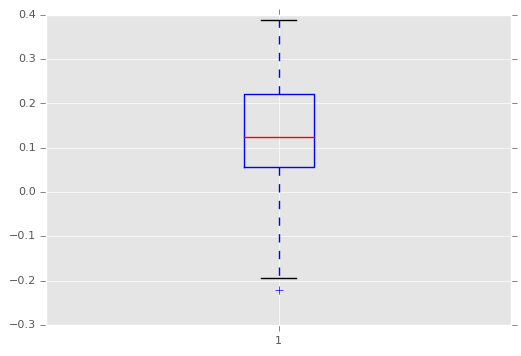

In [64]:
test_aucs = np.array(test_aucs)
plt.clf()
plt.boxplot(test_aucs[:,2]-test_aucs[:,0])
plt.show()

In [71]:
test_log_aucs = np.array(test_log_aucs)
np.percentile(test_aucs[:,2]-test_aucs[:,0], 50)

0.12500000000000006

In [106]:
import sklearn
null_preds = binarize(C[:,2])
sklearn.metrics.roc_auc_score(binarize(y, 0.2).ravel(), null_preds.ravel())

0.7407407407407407

In [111]:
test_aucs = np.array(test_aucs)
print(np.median(test_aucs, axis=0))
print(np.median(test_aucs[:,2] - test_aucs[:,0]))

[ 0.72222222  0.83333333  0.88888889  0.88888889]
0.125


In [84]:
n_successes = len(np.where(test_aucs[:,2]-test_aucs[:,0] > 0.)[0])
nobs = test_aucs.shape[0]
statsmodels.stats.proportion.proportion_confint(count=n_successes, nobs=nobs, alpha=0.01, method='wilson')


(0.6798264673845551, 0.88284111998595116)

In [130]:
np.median(np.array(test_r2s),axis=0)

array([ 0.34512404,  0.45269463,  0.51711106,  0.42051639])

In [81]:
arrestin_vs_gprot_results = copy.deepcopy([test_accuracies, test_aucs, test_log_aucs, C_test_aucs, C_test_log_aucs, feature_importances])
import pickle
with open("%s/arrestin_vs_gprot_results_-0pt2_XP.pkl", "wb") as f:
    pickle.dump(arrestin_vs_gprot_results, f)

In [168]:
arrestin_vs_gprot_rfr_results = copy.deepcopy([test_r2s, rfr_feature_importances])
import pickle
with open("%s/arrestin_vs_gprot_rfr_results_XP.pkl", "wb") as f:
    pickle.dump(arrestin_vs_gprot_rfr_results, f)

In [ ]:
test_accuracies, test_aucs, test_log_aucs, C_test_aucs, C_test_log_aucs, feature_importances = arrestin_vs_gprot_results

In [ ]:
#gprotein_results = copy.deepcopy([test_accuracies, test_aucs, test_log_aucs, C_test_aucs, C_test_log_aucs, feature_importances])

In [58]:
import plots
reload(plots)
from plots import *
from sklearn import linear_model

def analyze_regression_experiment(test_r2s, feature_importances, feature_names,
                        X, y, X_df, top_clusters, common_agonists, experiment_name, save_dir):
    
    auc_df = pd.DataFrame(np.array(test_r2s), columns=feature_names)    
    plt.style.use('ggplot')
    plt.figure(figsize=(5, 5))
    sns.set_style("darkgrid")
    #g = (auc_df
    #    .pipe((sns.violinplot, 'data'), orient='v', cut=0.))
    g = (auc_df
        .pipe((sns.boxplot, 'data'), orient='v', showfliers=False))
    g.set_xticklabels(auc_df.columns.values, rotation=90)
    sns.despine()
    plt.title(experiment_name)
    plt.ylabel("Frequency of R^2 over Random Splits")
    plt.xlabel("Featurization")
    plt.tight_layout()

    plt.savefig("%s/%s_r2s.pdf" %(save_dir, experiment_name))
    plt.show()
    plt.clf()
    
    docking_importances = [f[2] for f in feature_importances]
    importances_df = make_importances_df(docking_importances, top_clusters)
    importances_df.iloc[0:25].plot(kind='barh')
    print(importances_df)
    plt.xlabel("Feature Importance")
    plt.ylabel("MSM State")
    plt.title(experiment_name)
    plt.tight_layout()


    plt.savefig("%s/%s_feature_importances.pdf" %(save_dir, experiment_name))
    plt.clf()

    cs = np.logspace(-3., 20.)
    print("Computing regularization path ...")
    clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
    coefs_ = []
    for c in cs:
        clf.set_params(C=c)
        clf.fit(X, binarize(y, 0.2))
        coefs_.append(clf.coef_.ravel().copy())
    
    max_features = 5
    coefs_ = pd.DataFrame(np.array(coefs_), columns=top_clusters, index=np.log10(cs))
    coefs_[importances_df.iloc[:max_features].index].plot(colormap='RdYlBu')
    plt.xlabel("Lasso Parameter")
    plt.ylabel("Coefficient")
    plt.title(experiment_name)
    plt.tight_layout()


    plt.savefig("%s/%s_lasso.pdf" %(save_dir, experiment_name))
    plt.clf()
    
    plot_clustermap(X_df[common_agonists].loc[importances_df.index.values.tolist()[:max_features]].transpose(), save_file="%s/%s_ligands_vs_msm_states_ddg.pdf" %(save_dir, experiment_name), method='average', z_score=1)
    
    test_r2s = np.array(test_r2s)
    delta_r2s = np.zeros((test_r2s.shape[0], len(feature_names)-1))
    results_rows = [[np.median(test_r2s[:,0]), 0., (0, 0.)]]
    for i, name in enumerate(feature_names):
        if i == 0: continue
        delta_r2s[:,i-1] = test_r2s[:,i] - test_r2s[:,0]    
        n_successes = len(np.where(delta_r2s[:,i-1] > 0.)[0])
        nobs = delta_r2s.shape[0]
        confint = statsmodels.stats.proportion.proportion_confint(count=n_successes, nobs=nobs, alpha=0.01, method='wilson')
        results_rows.append([np.median(test_r2s[:,i]), np.median(delta_r2s[:,i-1]), confint])
    results_df = pd.DataFrame(results_rows, columns=["Median R^2", "Median delta R^2", "Sign Test 99% CI"], index=feature_names)
    
    return importances_df, results_df

    




In [59]:
import plots
reload(plots)
from plots import *
from sklearn import linear_model

def analyze_experiment(test_aucs, test_log_aucs, feature_importances, feature_names,
                        X, y, X_df, top_clusters, common_agonists, experiment_name, save_dir):
    
    auc_df = pd.DataFrame(np.array(test_aucs), columns=feature_names)    
    plt.style.use('ggplot')
    plt.figure(figsize=(5, 5))
    sns.set_style("darkgrid")
    g = (auc_df
        .pipe((sns.violinplot, 'data'), orient='v', cut=0.))
    #g = (auc_df
    #    .pipe((sns.boxplot, 'data'), orient='v', showfliers=True))
    g.set_xticklabels(auc_df.columns.values, rotation=90)
    sns.despine()
    plt.title(experiment_name)
    plt.ylabel("Frequency AUCs over Random Splits")
    plt.xlabel("Featurization")
    plt.tight_layout()

    plt.savefig("%s/%s_aucs.pdf" %(save_dir, experiment_name))
    plt.show()
    plt.clf()
    
    docking_importances = [f[1] for f in feature_importances]
    importances_df = make_importances_df(docking_importances, top_clusters)
    importances_df.iloc[0:25].plot(kind='barh')
    print(importances_df)
    plt.xlabel("Feature Importance")
    plt.ylabel("MSM State")
    plt.title(experiment_name)
    plt.tight_layout()


    plt.savefig("%s/%s_feature_importances.pdf" %(save_dir, experiment_name))
    plt.clf()

    cs = np.logspace(-3., 20.)
    print("Computing regularization path ...")
    clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
    coefs_ = []
    for c in cs:
        clf.set_params(C=c)
        clf.fit(X, y)
        coefs_.append(clf.coef_.ravel().copy())
    
    max_features = 5
    coefs_ = pd.DataFrame(np.array(coefs_), columns=top_clusters, index=np.log10(cs))
    coefs_[importances_df.iloc[:max_features].index].plot(colormap='RdYlBu')
    plt.xlabel("Lasso Parameter")
    plt.ylabel("Coefficient")
    plt.title(experiment_name)
    plt.tight_layout()


    plt.savefig("%s/%s_lasso.pdf" %(save_dir, experiment_name))
    plt.clf()
    
    plot_clustermap(X_df[common_agonists].loc[importances_df.index.values.tolist()[:max_features]].transpose(), save_file="%s/%s_ligands_vs_msm_states_ddg.pdf" %(save_dir, experiment_name), method='average', z_score=1)
    
    test_aucs = np.array(test_aucs)
    delta_aucs = np.zeros((test_aucs.shape[0], len(feature_names)-1))
    results_rows = [[np.median(test_aucs[:,0]), 0., (0, 0.)]]
    for i, name in enumerate(feature_names):
        if i == 0: continue
        delta_aucs[:,i-1] = test_aucs[:,i] - test_aucs[:,0]    
        n_successes = len(np.where(delta_aucs[:,i-1] > 0.)[0])
        nobs = delta_aucs.shape[0]
        confint = statsmodels.stats.proportion.proportion_confint(count=n_successes, nobs=nobs, alpha=0.01, method='wilson')
        results_rows.append([np.median(test_aucs[:,i]), np.median(delta_aucs[:,i-1]), confint])
    results_df = pd.DataFrame(results_rows, columns=["Median AUC", "Median delta AUC", "Sign Test 99% CI"], index=feature_names)
    
    
    return importances_df, results_df

    



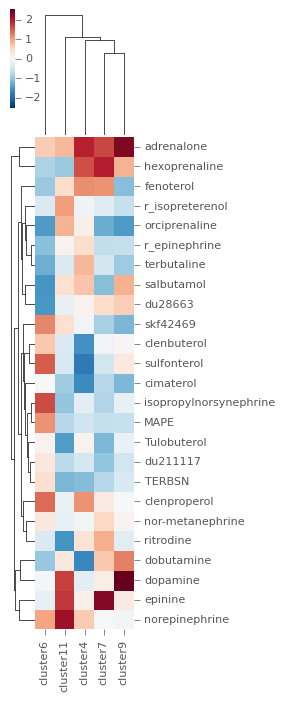

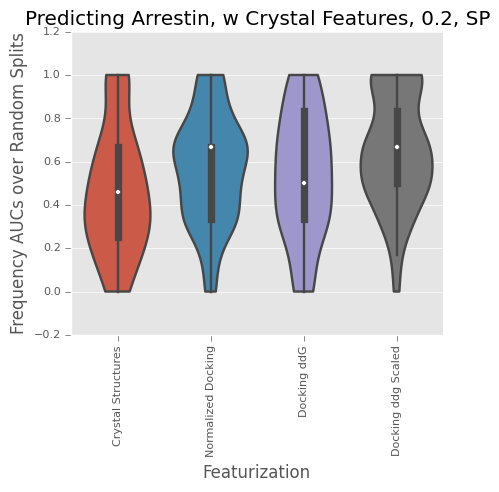

             importance
cluster4       0.099854
cluster11      0.098264
cluster6       0.066919
cluster16      0.044287
cluster15      0.042132
null_scores    0.038939
cluster12      0.038913
cluster24      0.038046
cluster1       0.037336
cluster7       0.031854
cluster2       0.031824
cluster3       0.030199
cluster22      0.029580
cluster19      0.028812
cluster20      0.028725
cluster8       0.028654
cluster17      0.028647
cluster14      0.027815
cluster18      0.024724
cluster23      0.024709
cluster9       0.024438
3p0g_grid      0.023743
cluster21      0.023700
cluster5       0.023506
cluster13      0.023233
2rh1_grid      0.021719
cluster10      0.021027
cluster0       0.018402
Computing regularization path ...


In [63]:
importances_df, results_df = analyze_experiment(test_aucs, test_log_aucs, feature_importances, feature_names,
                        X_scaled, y, pd.concat([ddg_scaled, null_features.transpose()], axis=0) , top_clusters.tolist() + null_features.columns.values.tolist(), common_agonists, "Predicting Arrestin, w Crystal Features, 0.2, SP", analysis_dir)

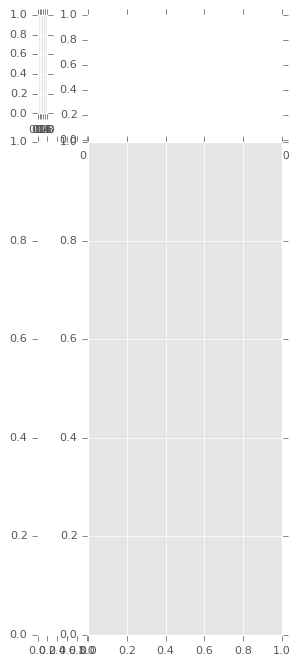

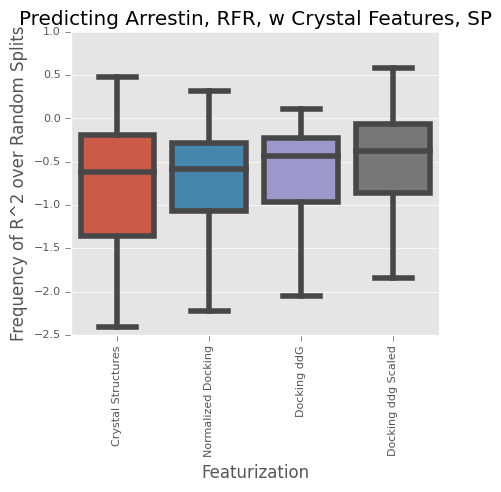

             importance
cluster4       0.076637
cluster11      0.072685
cluster7       0.058601
cluster9       0.057130
cluster6       0.047323
cluster5       0.045866
cluster10      0.039627
cluster15      0.037434
cluster17      0.035077
cluster0       0.033278
cluster22      0.032433
cluster18      0.031664
cluster13      0.031302
cluster23      0.030898
cluster12      0.029750
null_scores    0.029748
cluster24      0.029574
cluster21      0.028155
cluster8       0.027508
cluster16      0.027266
cluster19      0.026293
cluster14      0.026241
cluster1       0.025930
2rh1_grid      0.025526
cluster2       0.025201
cluster20      0.025132
3p0g_grid      0.023314
cluster3       0.020409
Computing regularization path ...


In [60]:
importances_df, results_df = analyze_regression_experiment(test_r2s, rfr_feature_importances, feature_names,
                        X, y, pd.concat([delta_delta_g, null_features.transpose()], axis=0) , top_clusters.tolist() + null_features.columns.values.tolist(), common_agonists, "Predicting Arrestin, RFR, w Crystal Features, SP", analysis_dir)

In [131]:
np.

(25, 1)

In [61]:
results_df

,Median R^2,Median delta R^2,Sign Test 99% CI
Crystal Structures,-0.623273,0.000000,"(0, 0.0)"
Normalized Docking,-0.580824,0.076842,"(0.422754769098, 0.67102316213)"
Docking ddG,-0.438054,0.178787,"(0.501208911272, 0.742613709922)"
Docking ddg Scaled,-0.378586,0.264237,"(0.604026824924, 0.827351658727)"


In [144]:
np.array(test_r2s).shape

(100, 4)

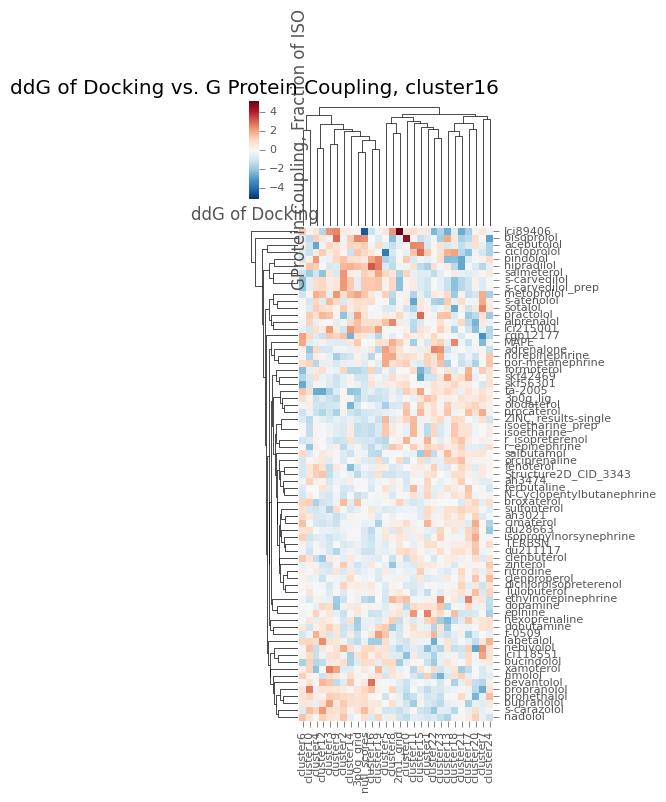

In [242]:
state = "cluster16"
plt.scatter(delta_delta_g[common_agonists].loc[state], y_gpr)
plt.xlabel("ddG of Docking")
plt.ylabel("GProtein Coupling, Fraction of ISO")
plt.title("ddG of Docking vs. G Protein Coupling, %s" %state)
plt.show()

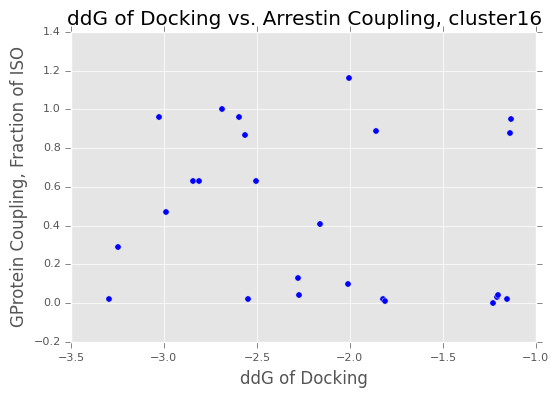

In [229]:
state = "cluster16"
plt.scatter(delta_delta_g[common_agonists].loc[state], y_arr)
plt.xlabel("ddG of Docking")
plt.ylabel("GProtein Coupling, Fraction of ISO")
plt.title("ddG of Docking vs. Arrestin Coupling, %s" %state)
plt.show()

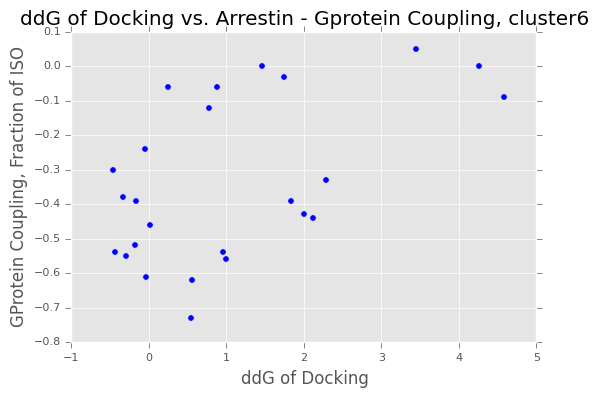

In [250]:
state = "cluster6"
plt.scatter(docking_normalized[common_agonists].loc[state], y_ori)
plt.xlabel("ddG of Docking")
plt.ylabel("GProtein Coupling, Fraction of ISO")
plt.title("ddG of Docking vs. Arrestin - Gprotein Coupling, %s" %state)
plt.show()

In [167]:
samples_pnas_tica.loc[importances_df.index.values[0:5]].dropna()

,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active,tIC.1,tIC.2
cluster9,6.671826,0.491837,0.876782,0.385258,1.433035,-0.646973,-1.624931
cluster3,13.353683,0.579279,0.802554,0.792276,1.433377,0.272626,1.953814
cluster2,14.403458,0.994941,0.268876,1.831260,1.361117,-0.844212,0.639414
cluster16,12.191679,0.364214,0.987019,0.315764,1.346833,-0.490035,1.479030


In [113]:
def get_top_measurable_features(samples_normalized_features_avg_df, cluster_name):
    import re
    top_features_cluster = []
    #top_features_cluster = samples_normalized_features_avg_df.loc["cluster_name"].loc[samples_normalized_features_avg_df.loc["cluster_name"].abs() > .75].index.values
    #print(top_features_cluster)
    #print(len(top_features_cluster))
    [top_features_cluster.append(pair) for pair in samples_normalized_features_avg_df.loc[cluster_name].abs().sort(inplace=False, ascending=False).index.values[:10]]
    all_features = []
    features = []
    for f in top_features_cluster:
        fs = f.split(",")
        for i in range(0, len(fs)):
            res = int(re.findall(r'\d+', fs[i])[0])
            all_features.append(res)
            if "TRP" in fs[i] or "CYS" in fs[i] or "TYR" in fs[i] or "LYS" in fs[i]:
                features.append(res)
            
    top_features_cluster = sorted(list(set(features)))
    #print(sorted(list(set([int(re.findall(r'\d+', r)[0]) for r in all_features]))))
    #print(top_features_cluster)
    return top_features_cluster, all_features
a, b = get_top_measurable_features(samples_normalized_features_averages_df, 6)

In [114]:
print(b)

[168, 184, 86, 184, 31, 58, 267, 57, 289, 98]


In [115]:
ddg_scaled[["norepinephrine", "r_epinephrine", "ethylnorepinephrine", "nebivolol", "s-carvedilol", "s-carazolol"]]

,norepinephrine,r_epinephrine,ethylnorepinephrine,nebivolol,s-carvedilol,s-carazolol
cluster0,-0.659121,-1.264705,-0.241250,-1.908652,-1.102187,-1.661670
cluster1,1.561117,1.534362,0.875280,-0.625821,0.085957,-0.057642
cluster2,-1.054903,-1.215426,-1.058710,1.663154,1.897511,0.954526
cluster3,-0.427444,-0.515659,-0.460569,0.011403,0.276647,0.748661
cluster4,-0.495017,-0.535371,-0.640011,-1.263044,-0.295423,-0.160574
cluster5,2.140310,0.243243,0.356891,1.428387,1.076077,0.345509
cluster6,-0.987330,-1.126723,-1.278029,-0.994740,-2.349005,-1.455806
cluster7,-0.697734,-1.107011,-0.390786,0.522859,-1.153527,-0.975455
cluster8,-0.002703,-0.279118,-0.171467,-1.363659,-0.449441,-1.404340
cluster9,-1.547217,0.006702,-1.587069,0.321630,0.210639,0.328354


In [298]:
print(np.mean(test_aucs, axis=0))
print(np.median(test_aucs, axis=0))
print(np.mean(test_log_aucs, axis=0))
print(np.median(test_log_aucs, axis=0))



[ 0.63541667  0.81783333  0.71433333  0.84783333]
[ 0.66666667  0.83333333  0.66666667  0.83333333]
[ 0.08048928  0.06490279  0.09441961  0.07177121]
[ 0.05869709  0.05869709  0.10886875  0.05869709]


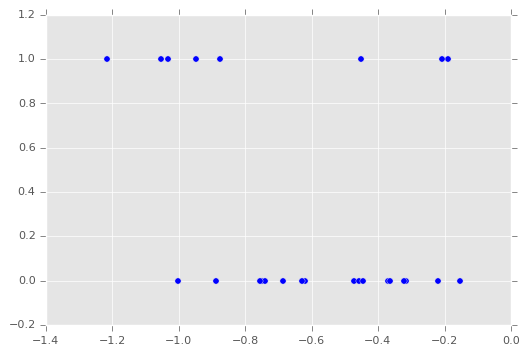

In [297]:
plt.scatter(ddg_scaled.loc["cluster2"][common_agonists], y)

In [ ]:
y_ori = bret["B2AR-Gprotein, Mean"].loc[common_agonists].values.reshape((-1,1))
y = binarize(y_ori, threshold=0.05)

X = delta_delta_g.loc[top_clusters][common_agonists].values.T
X_scaled = ddg_scaled.loc[top_clusters][common_agonists].values.T
C = null_features.loc[common_agonists].values
D_scaled = docking_normalized.loc[top_clusters][common_agonists].values.T

X_train = D_scaled
y_train = y
f = np.zeros(X_train.shape[1])

rfr = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1, oob_score=True)
rfr.fit(X_train, y_train)

#top_indices = np.argsort(rfr.feature_importances_*-1.)[:min(20, X_train.shape[1])]
#rfr = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1, oob_score=True)
#X_train = X_train[:, top_indices]
#rfr.fit(X_train, y_train)
#f[top_indices] = rfr.feature_importances_
#y_pred = rfr.predict(X_train)
#y_score = rfr.predict_proba(X_train)
top_indices=range(0,100)

In [ ]:
top_indices

In [ ]:
X_scaled.shape

In [ ]:
#G Protein, Agonist Results
test_drugs = secret_compounds + ["nebivolol", "s-carvedilol", "xamoterol", "3p0g_lig", "isoetharine", "ethylnorepinephrine", "N-Cyclopentylbutanephrine", "ta-2005", "procaterol"]
X_test = docking_normalized.transpose().loc[test_drugs].values[:, top_indices]
print(X_test)
pd.DataFrame(rfr.predict_proba(X_test), index=test_drugs, columns=["P(Antagonist", "P(Agonist)"])

In [ ]:
#ARRESTIN, Agonist Results
X_test = docking_normalized.transpose().loc[test_drugs].values[:, top_indices]
X_test.shape
pd.DataFrame(rfr.predict_proba(X_test), index=test_drugs, columns=["P(Antagonist", "P(Agonist)"])

In [ ]:
#G Protein, Full Agonist Results
test_drugs = secret_compounds + ["nebivolol", "s-carvedilol", "xamoterol", "3p0g_lig", "isoetharine", "ethylnorepinephrine", "N-Cyclopentylbutanephrine"]
X_test = docking_normalized.transpose().loc[test_drugs].values[:, top_indices]
pd.DataFrame(rfr.predict_proba(X_test), index=test_drugs, columns=["P(Antagonist", "P(Agonist)"])

In [ ]:
#ARRESTIN, Agonist Results
X_test = docking_normalized.transpose().loc[test_drugs].values[:, top_indices]
X_test.shape
pd.DataFrame(rfr.predict_proba(X_test), index=test_drugs, columns=["P(Antagonist", "P(Agonist)"])

In [ ]:
common_agonists = total_activity.loc[total_activity > 0.2].index.values
plt.scatter(docking_normalized.loc["cluster21"][common_agonists], bret["B2AR-Gprotein, Mean"].subtract(bret["B2AR-Arrestin, Mean"])[common_agonists])

In [ ]:
len(common_ligands)

In [ ]:
#ARRESTIN, Partial Agonist Results
X_test = docking_normalized.transpose().loc[test_drugs].values[:, top_indices]
X_test.shape
pd.DataFrame(rfr.predict_proba(X_test), index=test_drugs, columns=["P(Antagonist", "P(Agonist)"])

In [ ]:
#ARRESTIN, Full Agonist Results
X_test = docking_normalized.transpose().loc[test_drugs].values[:, top_indices]
X_test.shape
pd.DataFrame(rfr.predict_proba(X_test), index=test_drugs, columns=["P(Antagonist", "P(Agonist)"])

In [ ]:
top_indices

In [ ]:
ddg_scaled.transpose().loc[secret_compounds]

In [ ]:
plot_clustermap(docking_normalized[secret_compounds].iloc[top_indices].transpose(), save_file="%s/mehrdad_clustermap.pdf" %(save_dir), method='average', z_score=None)



In [ ]:
np.median(test_aucs, axis=0)

In [ ]:
plt.scatter(ddg_scaled.loc["cluster11"][common_agonists], y)



In [ ]:
arrestin_top = [16, 80, 43, 21, 84, 38, 44, 6, 13, 99]
gprot_top = [44, 6, 83, 4, 76, 99, 62, 92, 39, 80]

arrestin_only = sorted(list(set(arrestin_top).difference(set(gprot_top))))
print(arrestin_only)
gprot_only = sorted(list(set(gprot_top).difference(set(arrestin_top))))
print(gprot_only)
both = sorted(list(set(arrestin_top).intersection(set(gprot_top))))
print(both)


In [ ]:
samples_pnas_tica.loc[importances_df.index.values.tolist()[:5]]

In [ ]:
importances_df

In [ ]:
import sklearn
reload(sklearn)
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import binarize
from sklearn import cross_validation

test_accuracies = []
test_aucs = []
test_log_aucs = []
C_test_aucs = []
C_test_log_aucs = []
n_trials = 10
feature_importances = []
total_activity = bret["B2AR-Arrestin, Mean"].loc[common_ligands].add(bret["B2AR-Gprotein, Mean"].loc[common_ligands])
common_agonists = total_activity.loc[total_activity > 0.1].index.values

#biased_ligands = ["ethylnorepinephrine", "isoetharine", "N-Cyclopentylbutanephrine"]
#biased_ligands += ["nebivolol", "s-carvedilol"]
#non_biased_ligands =  ["r_isopreterenol", "r_epinephrine", "norepinephrine", "zinterol", "orciprenaline", "epinine", "terbutaline", "fenoterol", "procaterol", "formoterol", "salbutamol", "salmeterol"]
#non_biased_ligands += ["s-carazolol", "Ici215001", "bisoprolol", "timolol", "s-atenolol"]
#non_biased_ligands = [n for n in df.columns.values.tolist() if n not in biased_ligands and "Carvedilol" not in n]
#common_agonists = biased_ligands + non_biased_ligands
#common_agonists = common_ligands
#top_clusters = ["cluster80", "cluster62", "cluster11", "cluster21", "cluster16", "cluster43", "cluster38"]
#differences = np.zeros((len(top_clusters), len(top_clusters)))
#for i, cluster in enumerate(top_clusters):
#    for j in range(i, len(top_clusters)):
#        differences[i][j] = 

#top_clusters = importances_df.index.values
top_clusters = delta_delta_g.index.values

y_ori = bret["B2AR-Arrestin, Mean"].loc[common_agonists].subtract(bret["B2AR-Gprotein, Mean"].loc[common_agonists]).values.reshape((-1,1))
#y_ori = np.vstack([y_ori, np.ones(3).reshape((-1,1))])
#common_agonists = common_agonists.tolist() + biased_ligands

X = delta_delta_g.loc[top_clusters][common_agonists].values.T
X_scaled = ddg_scaled.loc[top_clusters][common_agonists].values.T
C = null_features.loc[common_agonists].values
D_scaled = docking_normalized.loc[top_clusters][common_agonists].values.T

#y = np.array([1. for n in biased_ligands] + [0. for n in non_biased_ligands]).reshape((-1,1))
#print(y_ori)
#y_ori = bret["B2AR-Arrestin, Mean"].loc[common_agonists].values.reshape((-1,1))
#plt.hist(y_ori, bins=25)
y = binarize(y_ori, threshold=-0.2)

features = [C, X_scaled, D_scaled]
features_y = [C, X_scaled, D_scaled, y]
feature_names = ["Crystal Structures", "MSM ddG", "Docking"]

In [ ]:
xt = ddg_scaled[biased_ligands].values.T
xt_preds = []


for j in range(0,n_trials):
    print(j)
    aucs = []
    log_aucs = []
    train_test_arrays = sklearn.cross_validation.train_test_split(*features_y, train_size=0.8, stratify=y) 
    y_train = train_test_arrays[2*len(features)]
    y_test = train_test_arrays[2*len(features) + 1]
    feature_importance = []
    
    for i in range(0, len(features)):
        X_train = train_test_arrays[2*i]
        X_test = train_test_arrays[2*i+1]

        sc = StandardScaler()
        sc.fit(X_train)
        X_train = sc.transform(X_train)
        X_test = sc.transform(X_test)

        rfr = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=3, n_jobs=-1, oob_score=True)
        rfr.fit(X_train, y_train)
        #top_indices = np.argsort(rfr.feature_importances_*-1.)[:min(10, X.shape[1])]
        feature_importance.append(rfr.feature_importances_)
        #rfr = RandomForestClassifier(n_estimators=10, max_features=None, n_jobs=-1, oob_score=True)
        #X_train = X_train[:, top_indices]
        #X_test = X_test[:, top_indices]
        #rfr.fit(X_train, y_train)
        #f = np.zeros(X.shape[1])
        #f[top_indices] = rfr.feature_importances_
        #feature_importance.append(f)
        
        if i == 1:
            xt_preds.append(rfr.predict(xt))
        
        y_pred = rfr.predict(X_test)
        y_score = rfr.predict_proba(X_test)
        auc, logauc = compute_auc(y_test, y_score)
        aucs.append(auc)
        log_aucs.append(logauc)  
    feature_importances.append(feature_importance)
    test_aucs.append(aucs)
    test_log_aucs.append(log_aucs)

In [ ]:
biased_ligands = ["ethylnorepinephrine", "isoetharine", "N-Cyclopentylbutanephrine"]

non_biased_ligands =  ["r_isopreterenol", "r_epinephrine", "norepinephrine", "zinterol", "orciprenaline", "epinine", "terbutaline", "fenoterol", "procaterol", "formoterol", "salbutamol", "salmeterol"]

ddg_scaled.loc[importances_df.index.values[:5]][biased_ligands + non_biased_ligands]

In [ ]:
ddg_scaled.sort("procaterol", inplace=False).iloc[:10]

In [ ]:
plt.scatter(ddg_scaled.loc["cluster36"][common_agonists], y)

In [ ]:
y

In [ ]:
import sklearn
reload(sklearn)
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import binarize
from sklearn import cross_validation

test_accuracies = []
test_aucs = []
test_log_aucs = []
C_test_aucs = []
C_test_log_aucs = []
n_trials = 1000
feature_importances = []
reg = []
total_activity = bret["B2AR-Arrestin, Mean"].loc[common_ligands].add(bret["B2AR-Gprotein, Mean"].loc[common_ligands])
common_agonists = total_activity.loc[total_activity > 0.3].index.values

#biased_ligands = ["ethylnorepinephrine", "isoetharine", "N-Cyclopentylbutanephrine", "3p0g_lig"]
#biased_ligands = ["nebivolol", "s-carvedilol"]
#non_biased_ligands =  ["r_isopreterenol", "r_epinephrine", "norepinephrine", "zinterol", "orciprenaline", "epinine", "terbutaline", "fenoterol", "procaterol", "formoterol", "salbutamol", "salmeterol"]
#non_biased_ligands = ["s-carazolol", "Ici215001", "bisoprolol", "timolol", "s-atenolol"]
#non_biased_ligands = [n for n in df.columns.values.tolist() if n not in biased_ligands and "Carvedilol" not in n]
#common_agonists = biased_ligands + non_biased_ligands

X = delta_delta_g[common_agonists].values.T
X_scaled = ddg_scaled[common_agonists].values.T
C = null_features.loc[common_agonists].values

#y = np.array([1. for n in biased_ligands] + [0. for n in non_biased_ligands]).reshape((-1,1))
#y_ori = bret["B2AR-Arrestin, Mean"].loc[common_ligands].divide(bret["B2AR-Arrestin, Mean"].loc[common_agonists].add(bret["B2AR-Gprotein, Mean"].loc[common_agonists])).values.reshape((-1,1))
y_ori = bret["B2AR-Arrestin, Mean"].loc[common_agonists].values.reshape((-1,1))
plt.hist(y_ori, bins=25)
y = binarize(y_ori, threshold=0.2) 

features = [C, X, X_scaled, docking_normalized[common_agonists].values.T]
features_y = [C, X, X_scaled, docking_normalized[common_agonists].values.T, y]
feature_names = ["Crystal Structures", "MSM States", "Normalized MSM States", "Normalized Docking"]
  

for j in range(0,n_trials):
    print(j)
    aucs = []
    log_aucs = []
    train_test_arrays = sklearn.cross_validation.train_test_split(*features_y, train_size=0.8, stratify=y) 
    y_train = train_test_arrays[2*len(features)]
    y_test = train_test_arrays[2*len(features) + 1]
    feature_importance = []
    r = []
    
    for i in range(0, len(features)):
        X_train = train_test_arrays[2*i]
        X_test = train_test_arrays[2*i+1]

        sc = StandardScaler()
        sc.fit(X_train)
        X_train = sc.transform(X_train)
        X_test = sc.transform(X_test)
        
        cs = np.logspace(-3., 20.)
        rfr = LogisticRegressionCV(Cs=cs, penalty='l2')
        rfr.fit(X_train, y_train)
        feature_importance.append(rfr.coef_)
        y_pred = rfr.predict(X_test)
        y_score = rfr.predict_proba(X_test)
        auc, logauc = compute_auc(y_test, y_score)
        aucs.append(auc)
        log_aucs.append(logauc)  
        r.append(rfr.C_)
    reg.append(r)
    feature_importances.append(feature_importance)
    test_aucs.append(aucs)
    test_log_aucs.append(log_aucs)

In [ ]:
plt.scatter(docking_normalized.loc["cluster80"][common_ligands], -1.0*bret.loc[common_ligands]["B2AR-Gprotein, Mean"].subtract(bret.loc[common_ligands]["B2AR-Arrestin, Mean"]))

In [ ]:
auc_df = pd.DataFrame(np.array(test_aucs), columns=feature_names)
auc_df.plot(kind='box')

In [ ]:
auc_df.median(axis=0)

In [ ]:
normalized_docking_importances = [f[1] for f in feature_importances]

In [ ]:
importances_df = make_importances_df(normalized_docking_importances, top_clusters)
importances_df


In [ ]:
from sklearn.preprocessing import binarize
X = ddg_scaled[common_ligands].values.T
y = bret["B2AR-Gprotein, Mean"].loc[common_ligands].values.reshape((-1,1))
y = binarize(y, threshold=0.5)
print(np.shape(y))
from sklearn.svm import l1_min_c
from sklearn import linear_model

#cs = l1_min_c(X, y, loss='log') * np.logspace(0, 3)
cs = np.logspace(-3., 20.)
print("Computing regularization path ...")
clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = pd.DataFrame(np.array(coefs_), columns=ddg_scaled.index.values, index=np.log10(cs))
#coefs_[list(set(inactive_clusters.tolist()).intersection(set(importances_df.iloc[10:20].index.values.tolist())))].plot()
coefs_[importances_df.index.values[:5]].plot()
#plt.plot(np.log10(cs), coefs_)
#ymin, ymax = plt.ylim()
###plt.xlabel('log(C)')
#plt.ylabel('Coefficients')
##plt.title('Logistic Regression Path')
#plt.axis('tight')
#plt.show()

In [ ]:
samples_pnas_tica.loc[importances_df.index.values[:10]]

In [ ]:
plt.scatter(deltas_tica.loc[importances_df.index.values[:10]]["tIC.6"], coefs_[importances_df.index.values[:10]].values[49])

In [ ]:
plot_clustermap(ddg_scaled[common_agonists.tolist()].loc[importances_df.index.values.tolist()[:5]].transpose(), save_file="%s/msm_n-clusters%d_lag-time%d_tICs%d.pdf" %(tica_dir, n_clusters, msm_lag_time, n_components), method='average')



In [ ]:
samples_pnas_tica.loc[samples_pnas_tica["tm6_tm3_dist"] < 18.0].loc[importances_df.iloc[0:5].index].dropna()

In [ ]:
ddg_scaled["nebivolol"].subtract(ddg_scaled["s-carazolol"]).sort(inplace=False).iloc[:10]

In [ ]:
ddg_scaled["s-carvedilol"].subtract(ddg_scaled["s-carazolol"]).sort(inplace=False).iloc[:10]

In [ ]:
samples_pnas_tica.loc[["cluster74", "cluster69", "cluster13", "cluster12", "cluster66"]]

In [ ]:
import plots
reload(plots)
from plots import *
#plot_importances_barh(importances_df.values, importances_df.index.values, "MSM State Importance in Arrestin Prediction", "Feature Importance", "MSM State", "%s/arrestin_0pt5_classification_rfr.pdf" %(tica_dir), n_features=50)
importances_df.iloc[0:25].plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("MSM State")
plt.title("Importance of MSM States in Predicting Arrestin Activity")
plt.savefig("%s/msm_%dstates_arrestin_0pt2_agonists_only_classification_rfr.pdf" %(tica_dir, n_clusters))
#plt.clf()


In [ ]:
X = docking_normalized[common_agonists].values.T
y = bret["B2AR-Arrestin, Mean"].subtract(bret["B2AR-Gprotein, Mean"]).loc[common_agonists].values.reshape((-1,1))
y = binarize(y, threshold=-0.2)
print(y)
from sklearn import linear_model

cs = np.logspace(-3., 200.)
clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = pd.DataFrame(np.array(coefs_), columns=ddg_scaled.index.values, index=np.log10(cs))
coefs_[importances_df.iloc[0:10].loc[samples_pnas_tica["tm6_tm3_dist"] < 9.].index].plot()
plt.xlabel("Log Regularization Parameter")
plt.ylabel("Coefficient for Arrestin Activity")
plt.title("Logistic Regression Coefficient in Predicting Arrestin Activity")
plt.savefig("%s/msm_%dstates_arrestin_0pt2_agonists_only_classification_logistic.pdf" %(tica_dir, n_clusters))
#plt.clf()

In [ ]:
np.shape(coefs_)

In [ ]:
print(np.median(np.nan_to_num(test_aucs)))
print(np.median(np.nan_to_num(C_test_aucs)))
print(np.median(np.nan_to_num(test_log_aucs)))
print(np.median(np.nan_to_num(C_test_log_aucs)))

In [ ]:
lr = LinearRegression()
states = importances_df.index.values.tolist()
model = lr.fit(X, y_ori)
pd.DataFrame(model.coef_.T, index=delta_delta_g.index, columns=["importance"]).loc[states]#.sort("importance", inplace=False)

In [ ]:
model.coef_.shape

In [ ]:
import seaborn
reload(seaborn)
import seaborn as sns
plt.style.use('ggplot')
plt.figure(figsize=(5, 5))
sns.set_style("darkgrid")
g = (auc_df
    .pipe((sns.boxplot, 'data'), orient='v', showfliers=True))
g.set_xticklabels(auc_df.columns.values, rotation=90)
sns.despine()
plt.title("AUC for Arrestin Prediction")
plt.ylabel("Frequency AUCs over Random Splits")
plt.xlabel("Featurization")
plt.show()
plt.savefig("%s/auc_arrestin_prediction_all_ligands_0pt2_cutoff.pdf" %tica_dir)

In [ ]:
corr_matrix = compute_pearson_matrix(delta_delta_g[common_agonists].values.T, y)
corr_df = pd.DataFrame(model.coef_.T, index=delta_delta_g.index.values, columns=["Correlation"]).sort("Correlation",inplace=False)
#corr_df.loc[["cluster80", "cluster16", "cluster43", "cluster44"]].plot(kind='barh')
corr_df.loc[importances_df.index.values[:20]].sort("Correlation", inplace=False).plot(kind='barh')#, figsize=(5,20))
plt.xlabel("Pearsson Correlation with Arrestin Activity")
plt.ylabel("MSM State")
plt.title("Correlation of MSM States with Arrestin Activity")


In [ ]:
samples_pnas_tica.loc[corr_df.loc[importances_df.index.values[:20]].sort("Correlation", inplace=False).index.values]

In [ ]:
df = copy.deepcopy(aggregate_docking_msm)
df[df.columns.values] = scale(df.values)
plt.scatter(df[common_ligands].loc["cluster13"].values, bret["B2AR-Arrestin, Mean"].loc[common_ligands].values.T)

In [ ]:
bret

In [ ]:
import sklearn
reload(sklearn)
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import binarize
from sklearn import cross_validation

test_accuracies = []
test_aucs = []
test_log_aucs = []
C_test_aucs = []
C_test_log_aucs = []
n_trials = 100
feature_importances = []

for j in range(0,n_trials):
    print(j)

    X = delta_delta_g[common_ligands].values.T
    C = null_features.loc[common_ligands].values
    y = bret["B2AR-Arrestin, Mean"].loc[common_ligands].values.reshape((-1,1))
    y = binarize(y, threshold=0.5)

    X_train, X_test, y_train, y_test, C_train, C_test = sklearn.cross_validation.train_test_split(X, y, C, train_size=0.8, stratify=y)
    
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    sc = StandardScaler()
    sc.fit(C_train)
    C_train = sc.transform(C_train)
    C_test = sc.transform(C_test)
 
    rfr = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=2, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train)
    feature_importances.append(rfr.feature_importances_)
    y_pred = rfr.predict(X_test)
    test_accuracies.append(np.sqrt(np.mean(np.square(y_test-y_pred.reshape((-1,1))))))
    y_score = rfr.predict_proba(X_test)
    auc, logauc = compute_auc(y_test, y_score)
    test_aucs.append(auc)
    test_log_aucs.append(logauc)
    
    rfr = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=2, n_jobs=-1, oob_score=True)
    rfr.fit(C_train, y_train)
    C_y_pred = rfr.predict(C_test)
    y_score = rfr.predict_proba(C_test)
    auc, logauc = compute_auc(y_test, y_score)
    C_test_aucs.append(auc)
    C_test_log_aucs.append(logauc)

    
    

    

In [ ]:
import seaborn
reload(seaborn)
import seaborn as sns
auc_df = pd.DataFrame(np.vstack([test_aucs, C_test_aucs]).T, columns=["MSM States", "Crystal Structures"])

plt.style.use('ggplot')
plt.figure(figsize=(5, 5))
sns.set_style("darkgrid")
g = (auc_df
    .pipe((sns.boxplot, 'data'), orient='v', showfliers=True))
#g.set_xticklabels(experiments.columns.values, rotation=90)
sns.despine()
plt.title("AUC for G Protein Prediction")
plt.ylabel("Frequency AUCs over Random Splits")
plt.xlabel("Featurization")
plt.show()
plt.savefig("%s/msm_n-states%d_auc_gprot_prediction_cutoff0pt5.pdf" %(tica_dir, n_clusters))

In [ ]:
importances_df = make_importances_df(feature_importances, delta_delta_g.index.values.tolist())
importances_df



In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression, Lasso
model = Lasso(alpha=0.0001)                                
model.fit(ddg_scaled[common_agonists].values.T, bret.loc[common_agonists]["B2AR-Arrestin, Mean"].subtract(bret.loc[common_agonists]["B2AR-Gprotein, Mean"].values))
pd.DataFrame(model.coef_, index=ddg_scaled.index, columns=["importance"]).sort("importance", inplace=False)

In [ ]:
print(np.median(np.nan_to_num(test_aucs)))
print(np.median(np.nan_to_num(C_test_aucs)))
print(np.median(np.nan_to_num(test_log_aucs)))
print(np.median(np.nan_to_num(C_test_log_aucs)))

In [ ]:
import plots
reload(plots)
from plots import *
#plot_importances_barh(importances_df.values, importances_df.index.values, "MSM State Importance in Arrestin Prediction", "Feature Importance", "MSM State", "%s/arrestin_0pt5_classification_rfr.pdf" %(tica_dir), n_features=50)
importances_df.iloc[0:25].plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("MSM State")
plt.title("Importance of MSM States in Predicting G Protein Activity")
#plt.savefig("%s/msm_%dstates_gprot_0pt5_classification_rfr.pdf" %(tica_dir, n_clusters))
#plt.clf()



In [ ]:
corr_matrix = compute_pearson_matrix(ddg_scaled[common_ligands].values.T, y)
corr_df = pd.DataFrame(model.coef_, index=ddg_scaled.index.values, columns=["Correlation"])
corr_df.loc[importances_df.index.values[:10]].sort("Correlation", inplace=False).plot(kind='barh')
plt.xlabel("Pearsson Correlation with G Protein Activity")
plt.ylabel("MSM State")
plt.title("Correlation of MSM States with G Protein Activity")
#plt.savefig("%s/msm_%dstates_gprot_0pt5_classification_correlations.pdf" %(tica_dir, n_clusters))
#plt.clf()




In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)